# Monte-carlo approach to APF calculations

To get an estimate of the uncertainty on Area-Peak Factor values derived from WD scans, we need to take into account uncertainty in the background fit.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import pandas as pd
import glob
from pathlib import Path
from scipy import ndimage
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "..")
from src.wdscan import select_roi, plot_bg_fit
from lmfit.models import LinearModel, ConstantModel, LorentzianModel, GaussianModel

np.random.seed(105)

from fitting_helper_funs import (
    simulate_spectra_montecarlo
    , fit_baseline_and_plot
    , fit_mc_bg
    , plot_mc_bg_fits
    , fit_multiple_gaussians
    , fit_multiple_gaussians_mc
)


# Import data

In [3]:
anu_data = {}

for xtl in ['LDE1', 'LDE1H']:
    files = glob.glob(f'../data/interim/peak_shapes/cleaned_data_ANU/{xtl}/*.csv')
    data = [pd.read_csv(f, index_col=0) for f in files]
    names = [Path(f).stem for f in files]
    anu_data[xtl] = dict(zip(names, data))
    
sta_data = {}

for xtl in ['LDE1', 'LDE1L']:
    files = glob.glob(f'../data/interim/peak_shapes/cleaned_data_StA/{xtl}/*.csv')
    data = [pd.read_csv(f, index_col=0) for f in files]
    names = [Path(f).stem for f in files]
    sta_data[xtl] = dict(zip(names, data))
    
data = {'ANU': anu_data, 'StA': sta_data}

# with open('data.pickle', 'wb') as f:
#     pickle.dump(data, f)

# Get noise via running mean and create synthetic datasets

First do this with just 10 mc simulations and plot the figures to check it works as expected

AlN


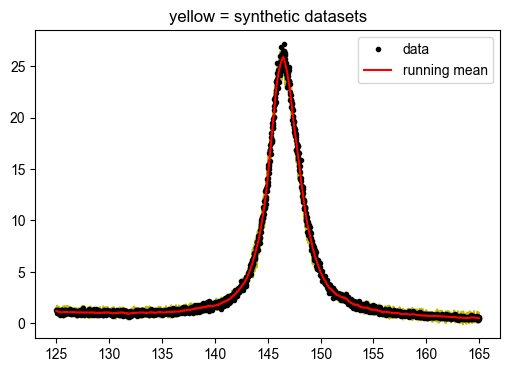

BN


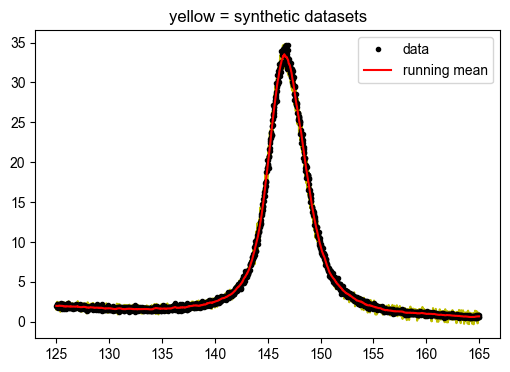

Buddingtonite


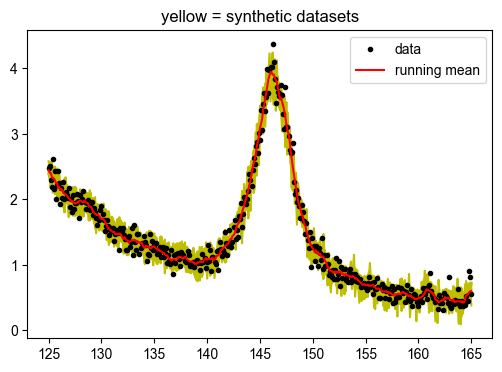

GaN


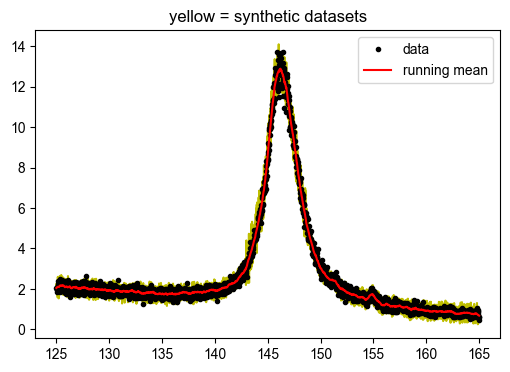

GlassA870


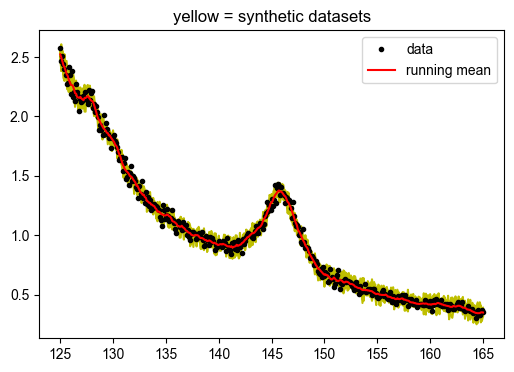

Si3N4


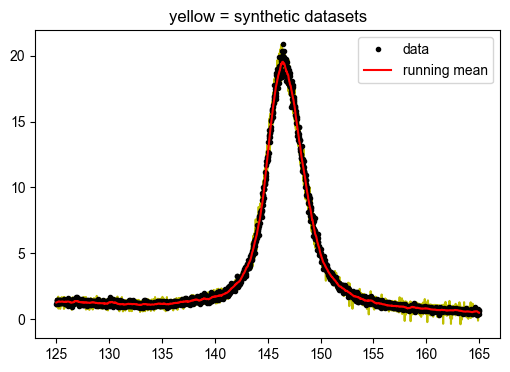

AlN


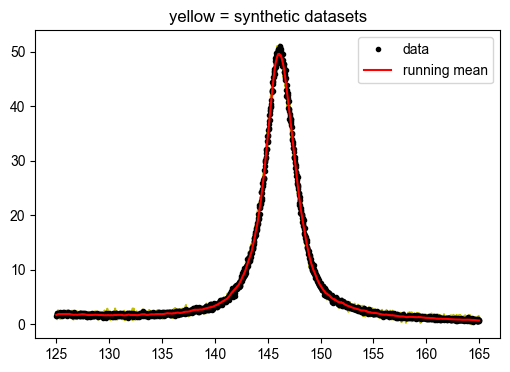

BN


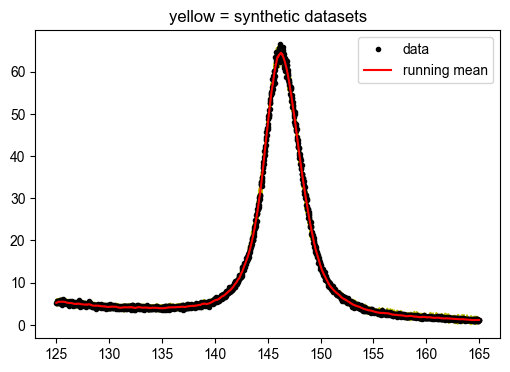

Buddingtonite


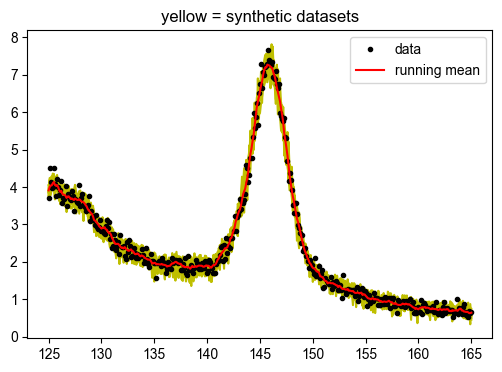

GaN


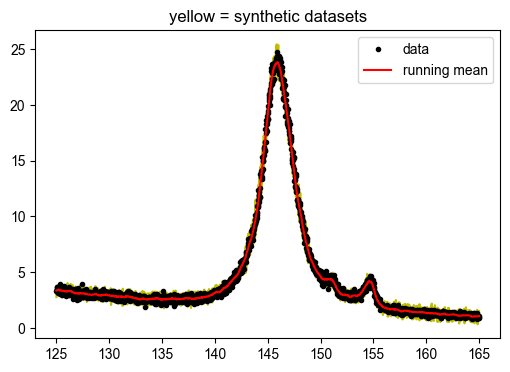

GlassA870


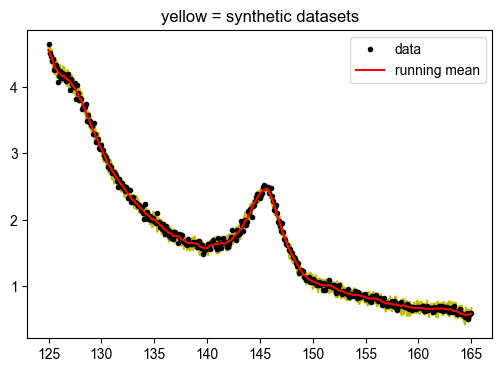

Si3N4


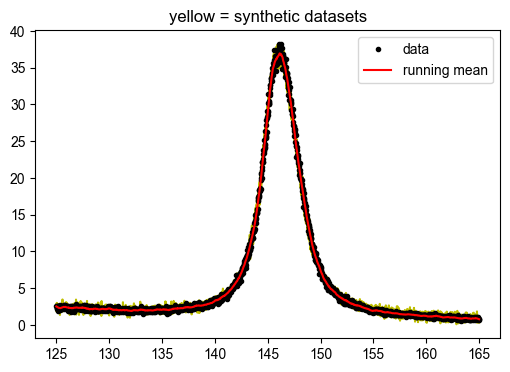

AlN


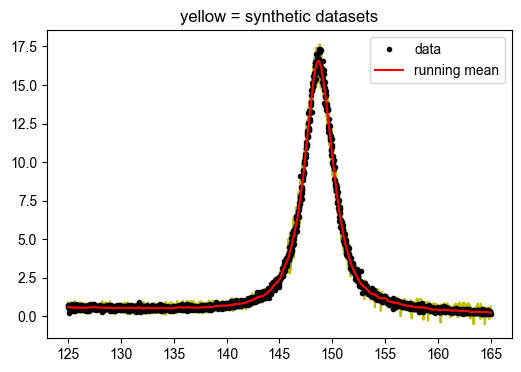

BN


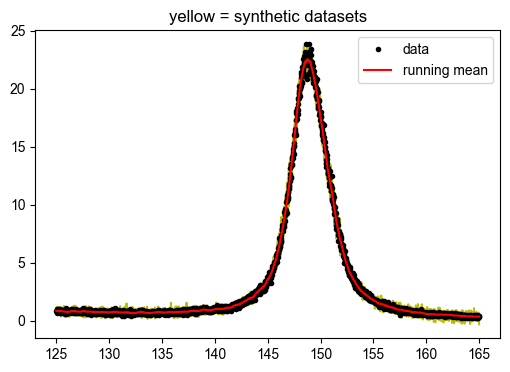

GaN


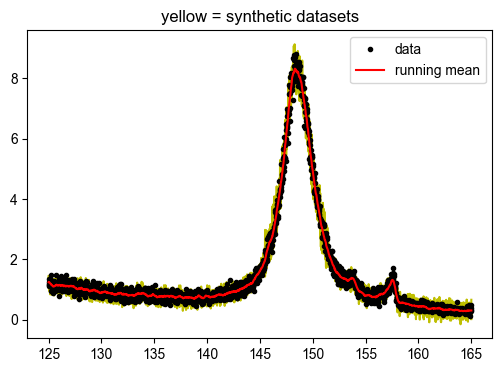

GlassA870


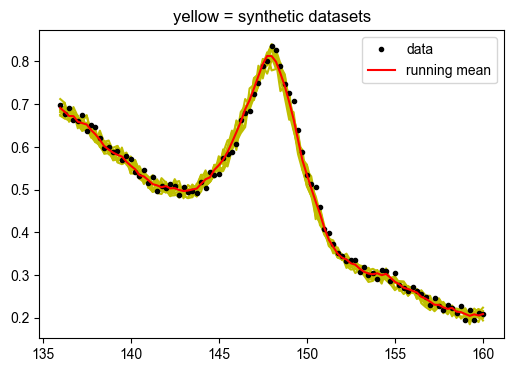

Si3N4


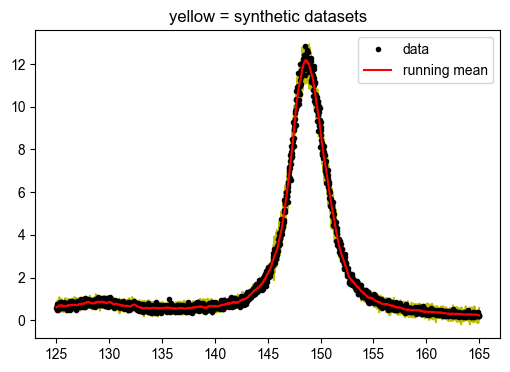

AlN


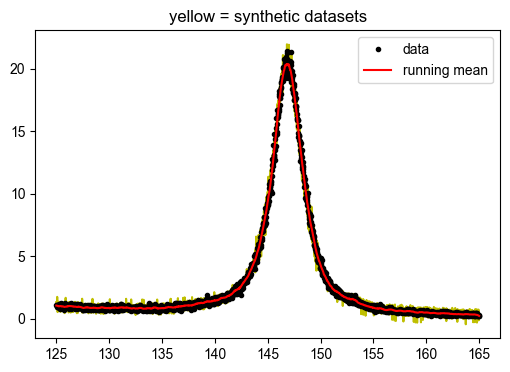

BN


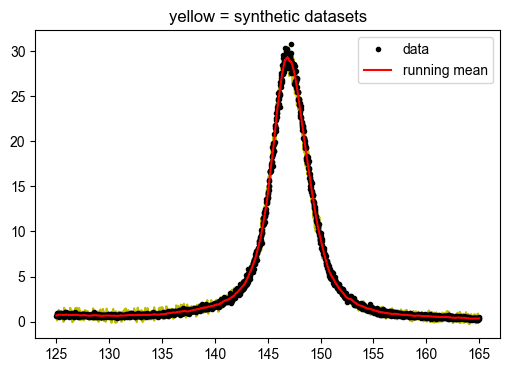

GaN


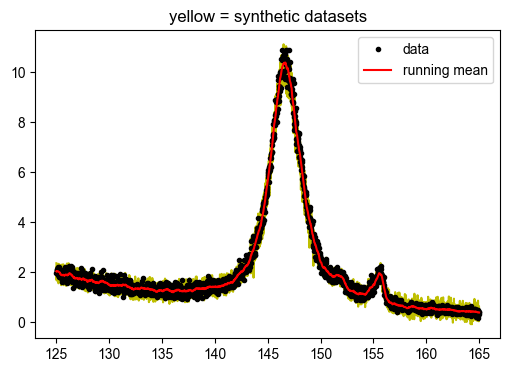

GlassA870


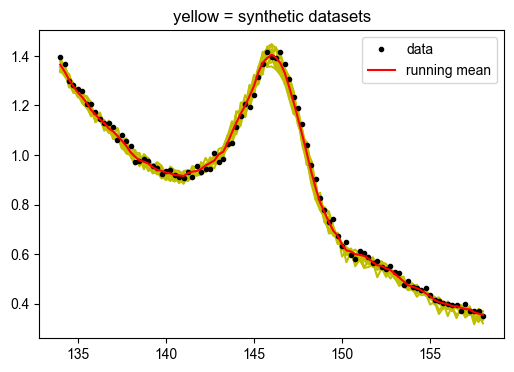

Si3N4


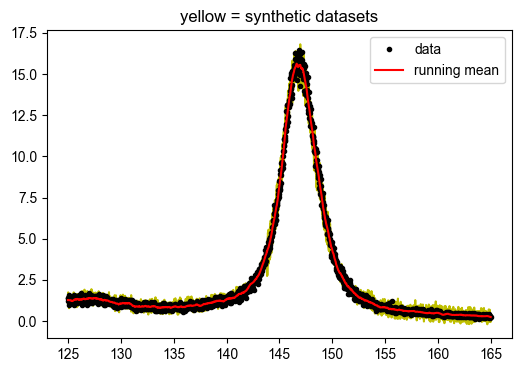

In [4]:
synthetic_data = {'ANU': {}, 'StA': {}}

for lab in ['ANU', 'StA']:
    
    for xtl in data[lab].keys():
        synthetic_data[lab][xtl] = {}
        
        for sample in data[lab][xtl].keys():
            print(sample)
            if sample in ['Buddingtonite', 'GlassA870']:
                if lab == 'StA':
                    window_size=4
                else:
                    window_size=9
            else:
                window_size=21
                
            synthetic_data[lab][xtl][sample] = simulate_spectra_montecarlo(
                                                        data[lab][xtl][sample],
                                                        window_size=window_size,
                                                        number_of_mc_simulations=10, plot=True)

Now do it again with 50 mc simulations and save the data.

In [5]:
NUM_MC_SIMS = 50

synthetic_data = {'ANU': {}, 'StA': {}}

for lab in ['ANU', 'StA']:
    
    for xtl in data[lab].keys():
        synthetic_data[lab][xtl] = {}
        
        for sample in data[lab][xtl].keys():
            
            if sample in ['Buddingtonite', 'GlassA870']:
                if lab == 'StA':
                    window_size=4
                else:
                    window_size=9
            else:
                window_size=21
                
            synthetic_data[lab][xtl][sample] = simulate_spectra_montecarlo(
                                                        data[lab][xtl][sample],
                                                        window_size=window_size,
                                                        number_of_mc_simulations=NUM_MC_SIMS, plot=False)

with open('../data/interim/peak_shapes/synthetic_data.pickle', 'wb') as f:
    pickle.dump(synthetic_data, f)
            
# To save the data in a structure similar to that of the "cleaned" data, uncomment the below:

#             output_folder = Path(f'./synthetic_data_{lab}/{xtl}/')
#             if not output_folder.exists():
#                 output_folder.mkdir(parents=True, exist_ok=True)
                
#             synthetic_data[lab][xtl][sample].to_csv(output_folder / Path(f'{sample}.csv'))

# Set up for background fitting

In [6]:
rois = {
    'StA': 
            {'LDE1': 
                {
                'AlN': np.array([[125,130], [164,165]])
                ,'BN': np.array([[129, 133], [164,165]])
                ,'GaN': np.array([[133, 136], [162,165]])
                ,'Si3N4': np.array([[134, 136], [162,165]])
                ,'GlassA870': np.array([[136, 142], [157,160]])
                ,'Buddingtonite': np.array([])
                }
            ,'LDE1L': 
                {
                'AlN': np.array([[130, 135], [162,165]])
                ,'BN': np.array([[128, 130], [164,165]])
                ,'GaN': np.array([[132, 136], [160,165]])
                ,'Si3N4': np.array([[133, 135], [162,165]])
                ,'GlassA870': np.array([[134, 140], [155,158]])
                ,'Buddingtonite': np.array([])
                }
            }
    
    ,'ANU':
            {'LDE1':
                {
                'AlN': np.array([[125,130], [162,165]])
                ,'BN': np.array([[129, 133], [162,165]])
                ,'GaN': np.array([[125, 133], [160,165]])
                ,'Si3N4': np.array([[128, 132], [162,165]])
                ,'GlassA870': np.array([[125,127], [132, 135], [157,165]])
                ,'Buddingtonite': np.array([[125,127], [132, 135], [157,165]])
                }
             ,'LDE1H':
                {
                'AlN': np.array([[125, 130], [162,165]])
                ,'BN': np.array([[129, 133], [162,165]])
                ,'GaN': np.array([[130, 135], [160,165]])
                ,'Si3N4': np.array([[128, 132], [162,165]])
                ,'GlassA870': np.array([[125,126], [132, 135], [157,165]])
                ,'Buddingtonite': np.array([[125,127], [132, 135], [157,165]])
                }}
        }


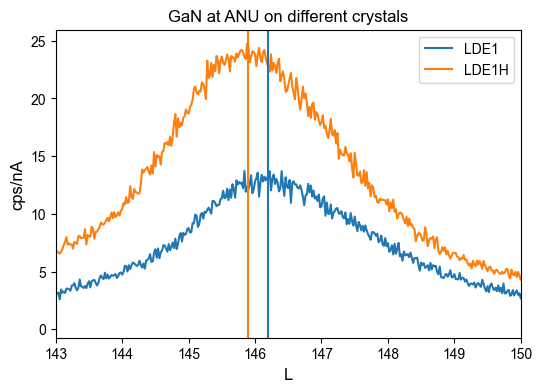

0.3


In [7]:
fig, ax = plt.subplots()
data['ANU']['LDE1']['GaN'].plot(x='L', y='cps_per_nA', ax=ax, label='LDE1')
data['ANU']['LDE1H']['GaN'].plot(x='L', y='cps_per_nA', ax=ax, label='LDE1H')
plt.xlim(143,150)
plt.axvline(146.2, color='tab:blue')
plt.axvline(145.9, color='tab:orange')
plt.xticks(np.arange(143,151))
plt.title('GaN at ANU on different crystals')
plt.ylabel('cps/nA')
plt.show()

anu_peak_pos_difference = 146.2 - 145.9
print(round(anu_peak_pos_difference,1))

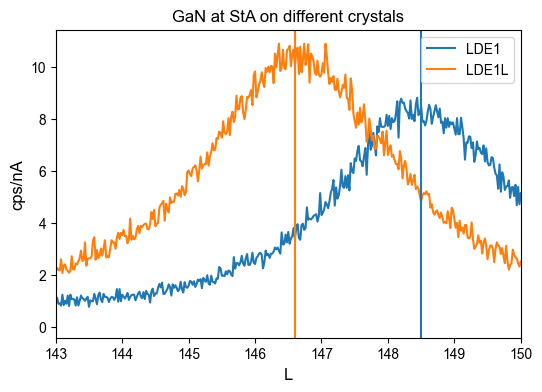

1.9


In [8]:
fig, ax = plt.subplots()
data['StA']['LDE1']['GaN'].plot(x='L', y='cps_per_nA', ax=ax, label='LDE1')
data['StA']['LDE1L']['GaN'].plot(x='L', y='cps_per_nA', ax=ax, label='LDE1L')
plt.xlim(143,150)
plt.axvline(148.5, color='tab:blue')
plt.axvline(146.6, color='tab:orange')
plt.xticks(np.arange(143,151))
plt.title('GaN at StA on different crystals')
plt.ylabel('cps/nA')
plt.show()

sta_peak_pos_difference = 148.5 - 146.6
print(round(sta_peak_pos_difference,1))

# Fit backgrounds to the original data


--- StA LDE1 AlN ---

--- StA LDE1 BN ---

--- StA LDE1 GaN ---

--- StA LDE1 GlassA870 ---

--- StA LDE1 Si3N4 ---

--- StA LDE1L AlN ---

--- StA LDE1L BN ---

--- StA LDE1L GaN ---

--- StA LDE1L GlassA870 ---

--- StA LDE1L Si3N4 ---

--- ANU LDE1 AlN ---

--- ANU LDE1 BN ---

--- ANU LDE1 Buddingtonite ---

--- ANU LDE1 GaN ---

--- ANU LDE1 GlassA870 ---

--- ANU LDE1 Si3N4 ---

--- ANU LDE1H AlN ---

--- ANU LDE1H BN ---

--- ANU LDE1H Buddingtonite ---

--- ANU LDE1H GaN ---

--- ANU LDE1H GlassA870 ---

--- ANU LDE1H Si3N4 ---


c:\Users\Eleanor\Dropbox\POSTDOC\1-Research\3-Manuscript\n_epma_analysis\notebooks\fitting_helper_funs.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,2))


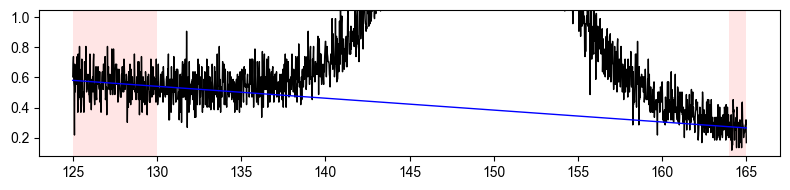

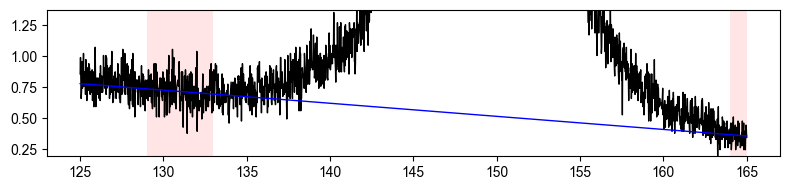

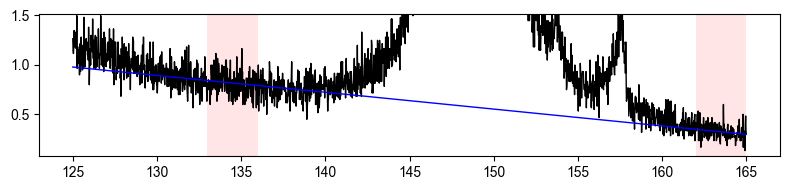

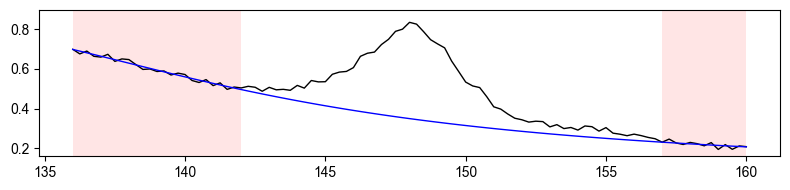

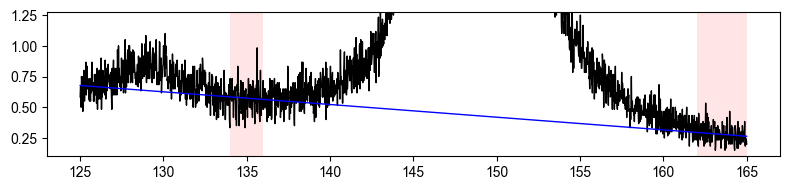

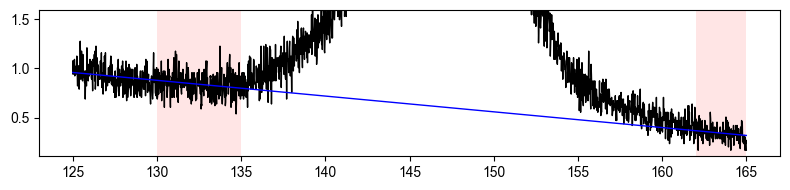

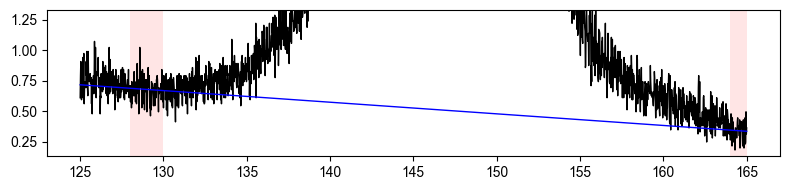

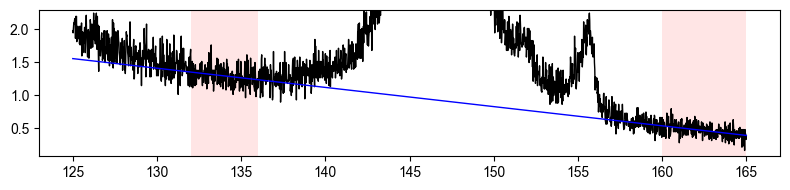

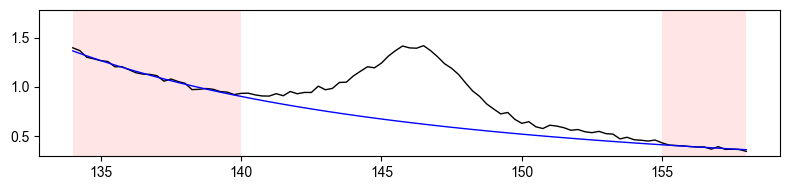

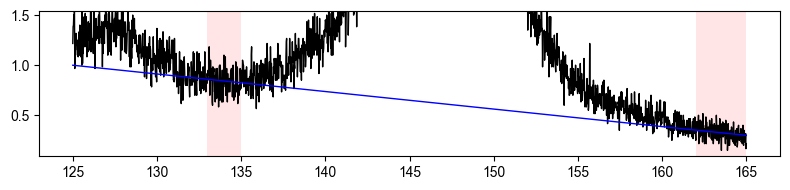

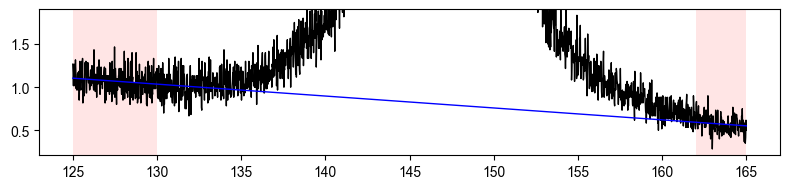

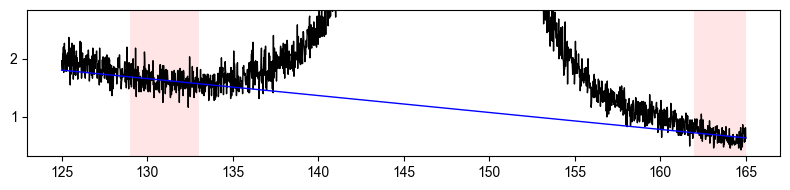

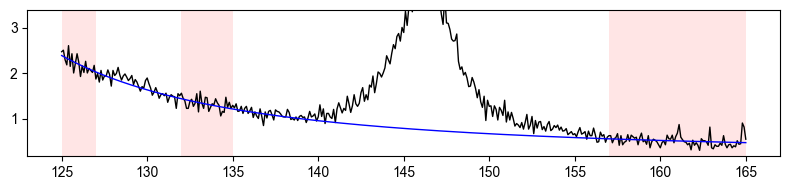

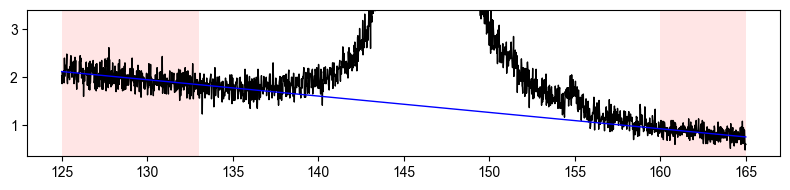

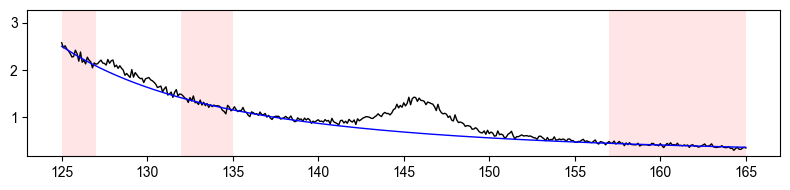

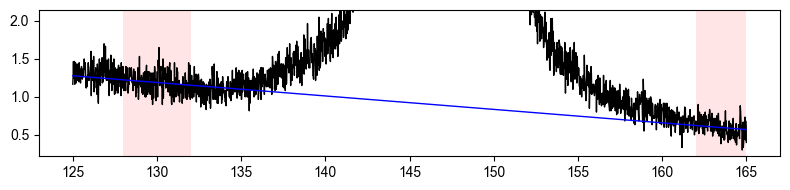

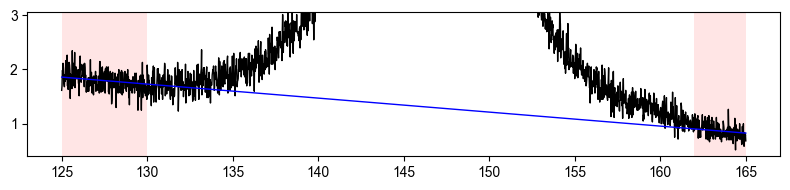

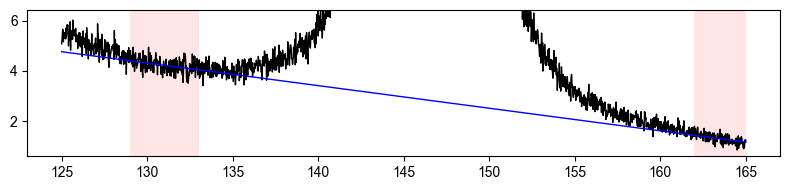

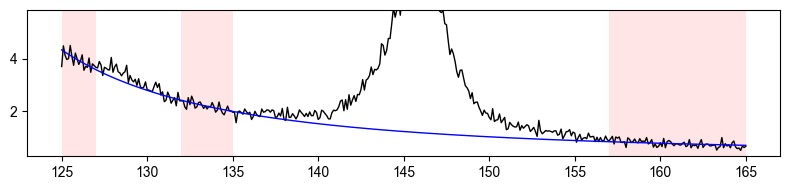

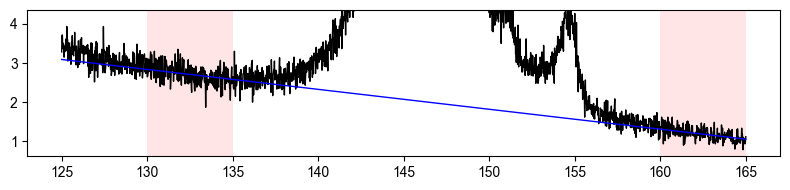

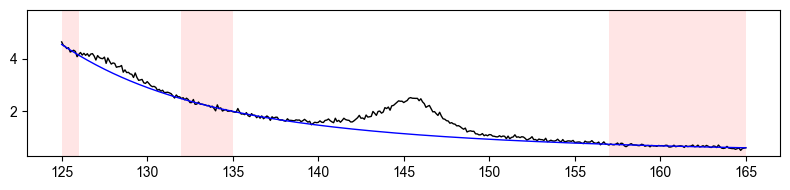

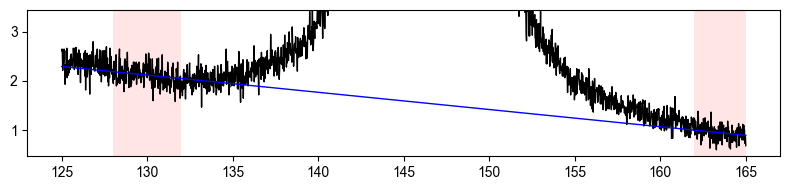

In [9]:
labs = ['StA', 'ANU']

# baselines = {'StA': {'LDE1': {}, 'LDE1L': {}}
#             ,'ANU': {'LDE1': {}, 'LDE1H': {}}}

# corrected_data = {'StA': {'LDE1': {}, 'LDE1L': {}}
#                  ,'ANU': {'LDE1': {}, 'LDE1H': {}}}

for lab in labs:
    
    for xtl in data[lab].keys():
    
        for s in data[lab][xtl].keys():
            
            roi = rois[lab][xtl][s]
            print(f'\n--- {lab} {xtl} {s} ---')
            
            if s not in ['Buddingtonite', 'GlassA870']:
                bg_type = 'linear'
            else:
                bg_type = 'lorentzian_plus_c'
                
            fit_baseline_and_plot(data[lab][xtl][s], roi, name=None, bg_type=bg_type)



--- StA LDE1 GaN ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- StA LDE1 AlN ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- StA LDE1 Si3N4 ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- StA LDE1 BN ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- StA LDE1L GaN ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of

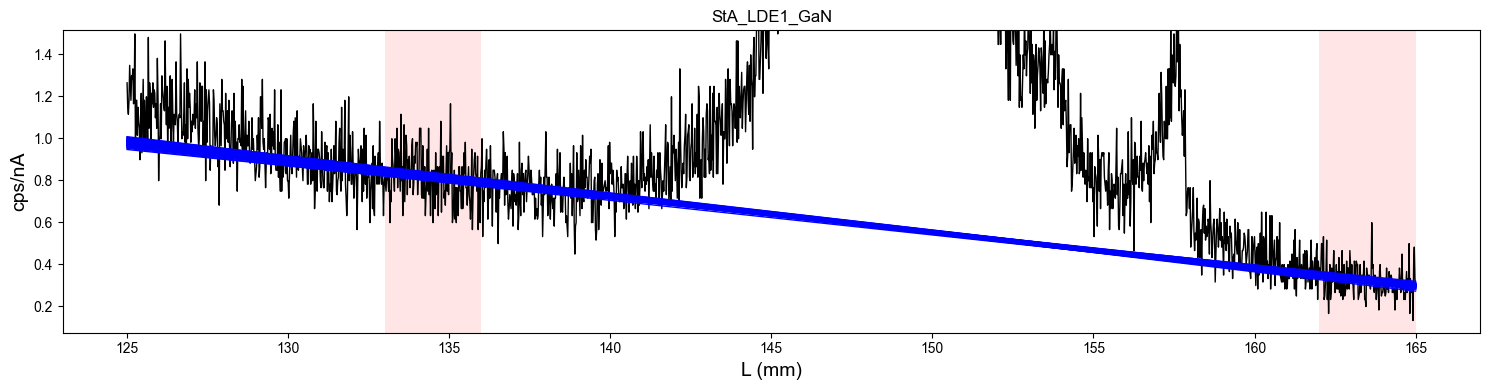

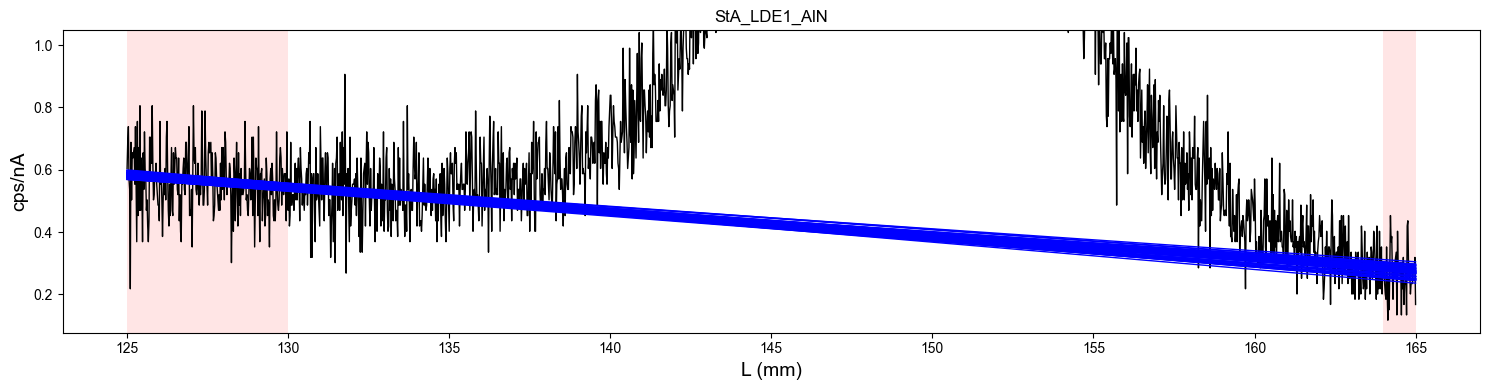

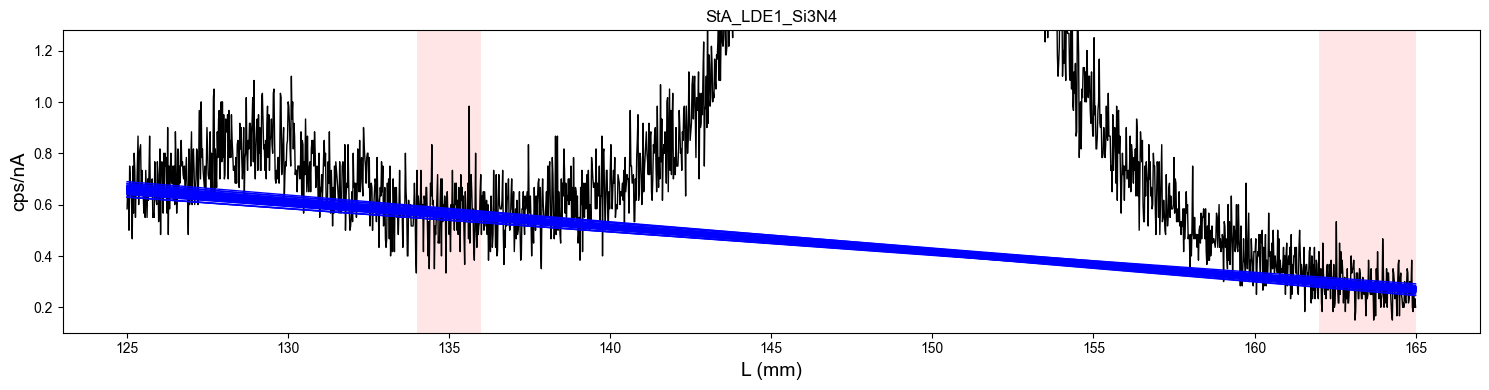

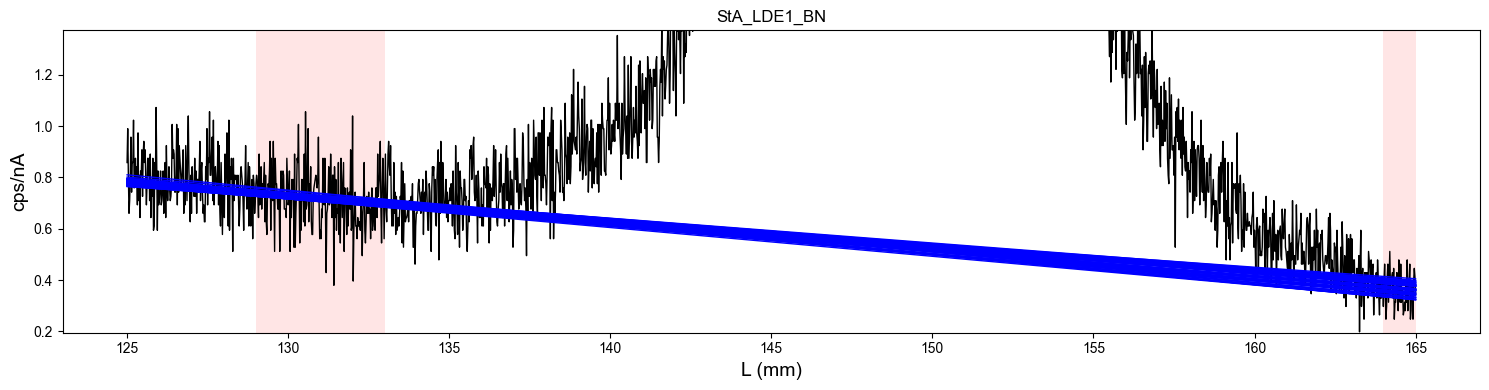

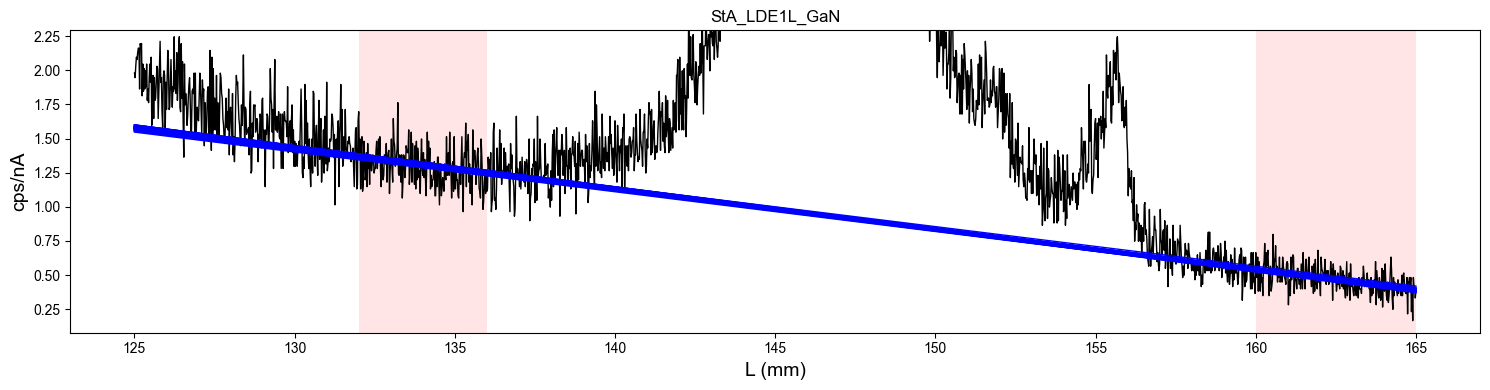

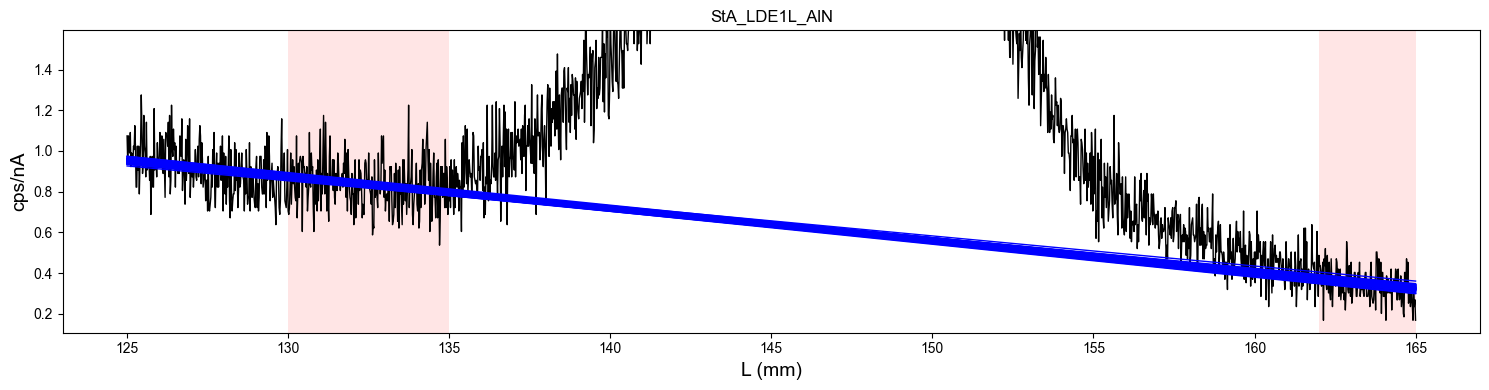

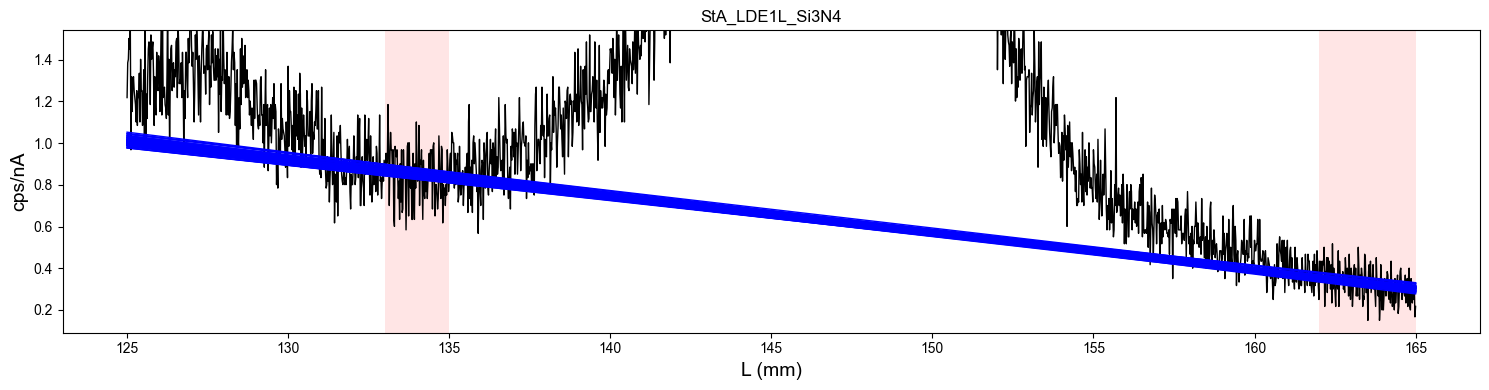

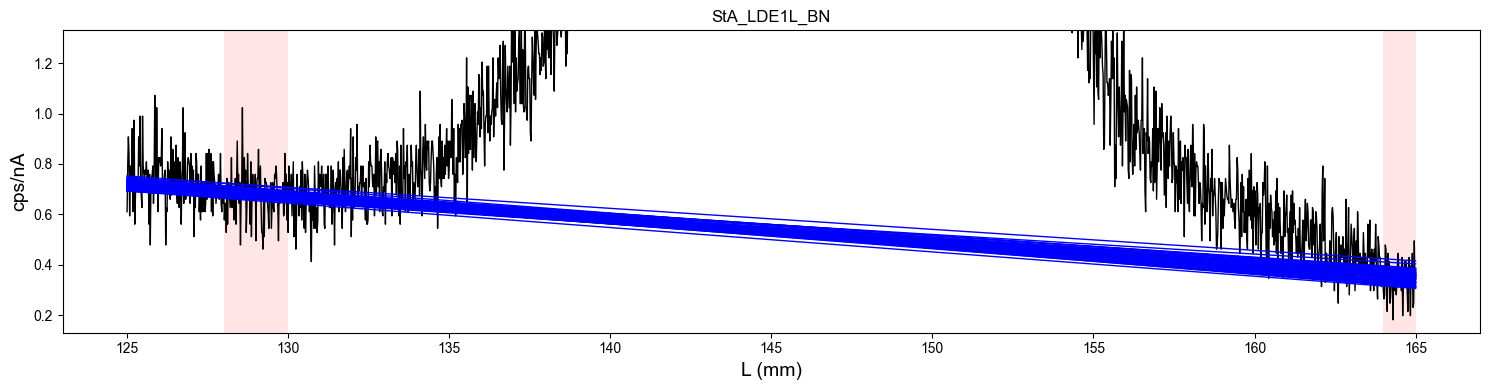

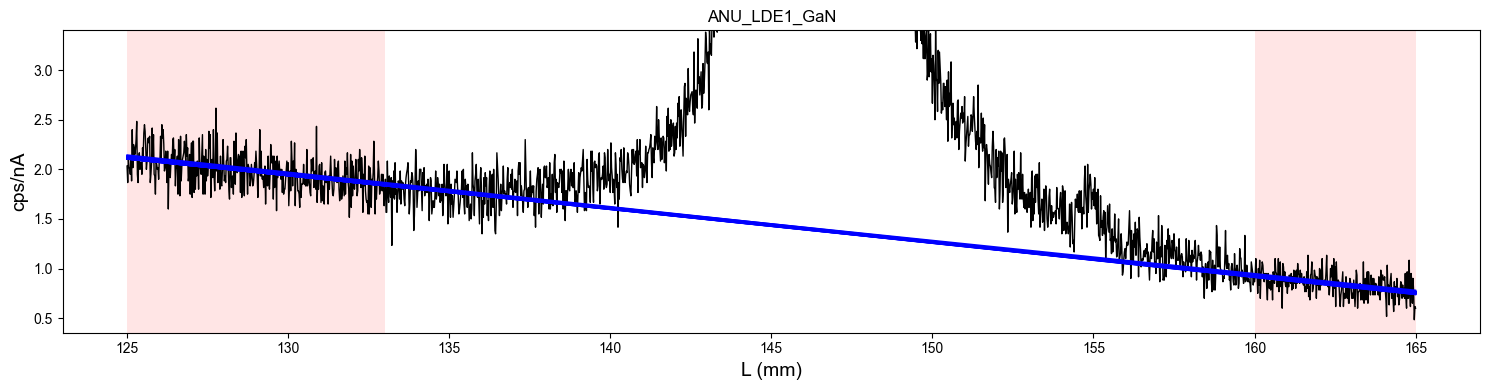

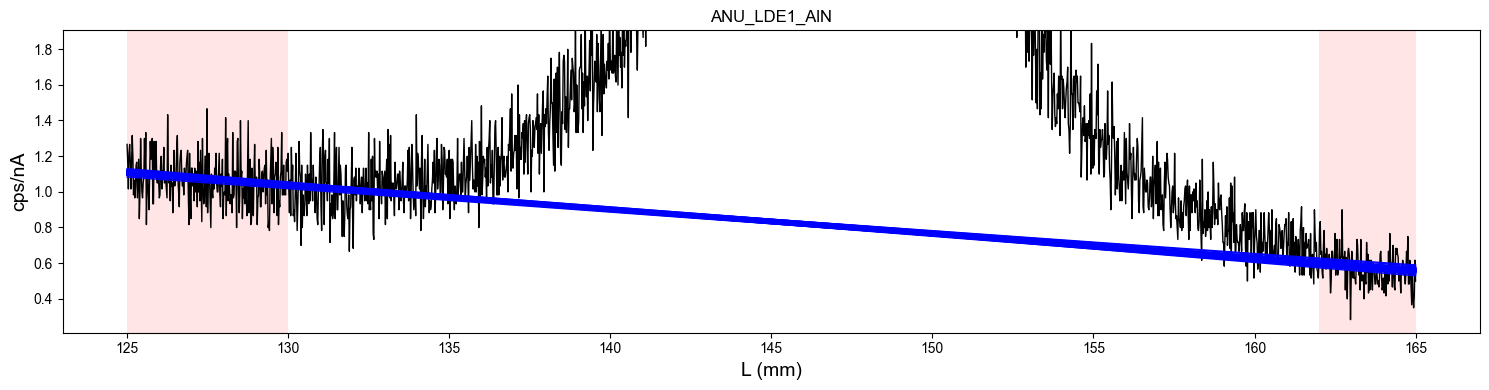

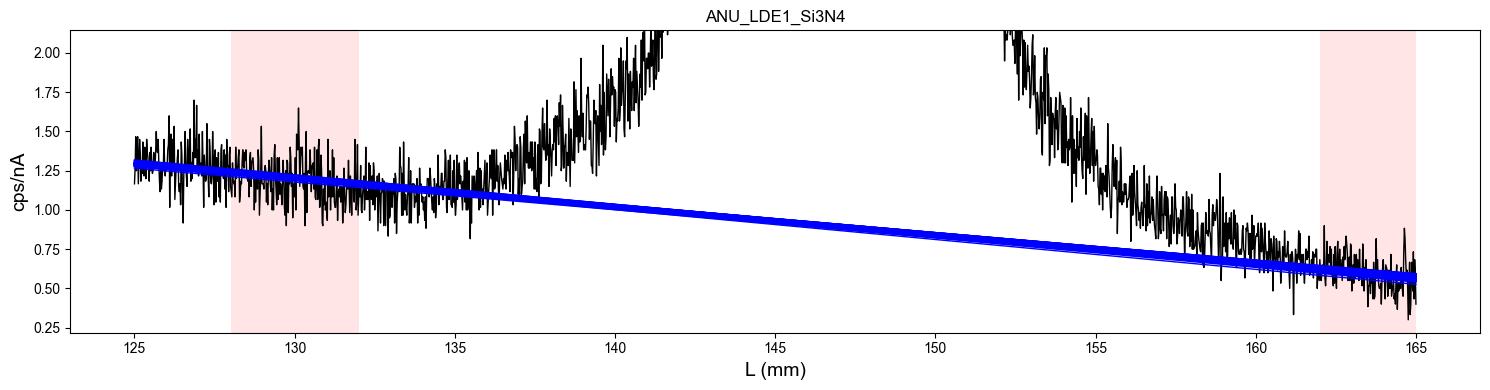

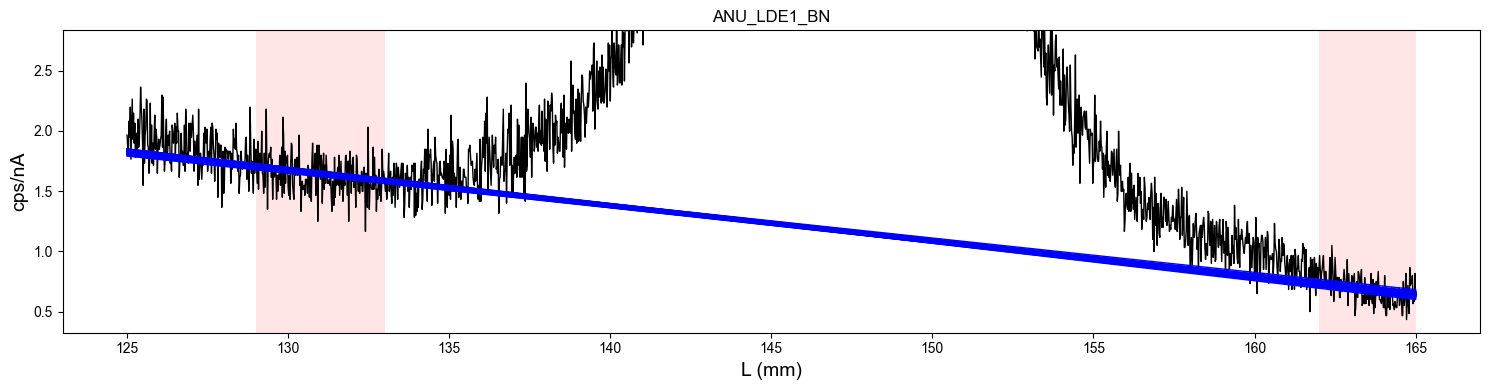

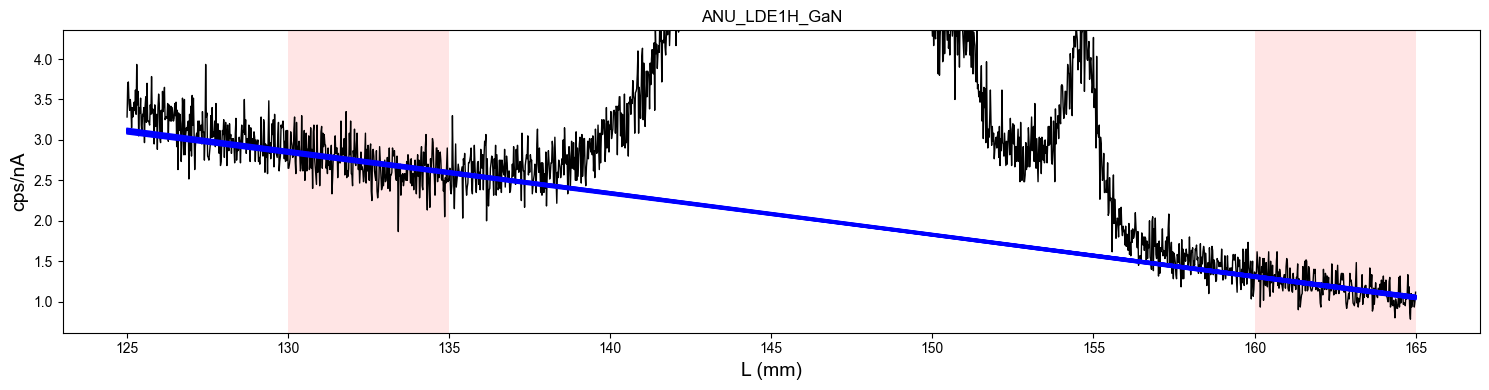

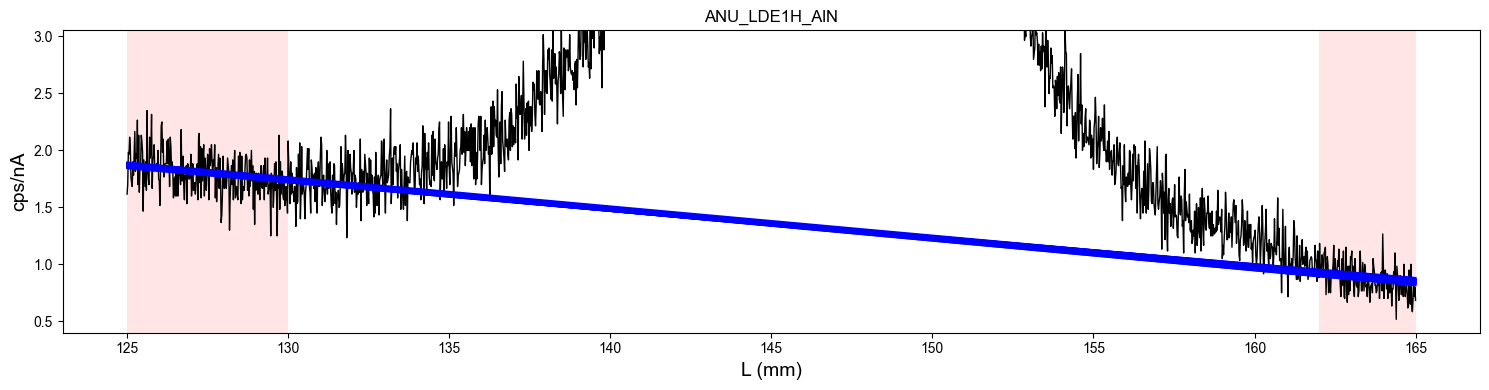

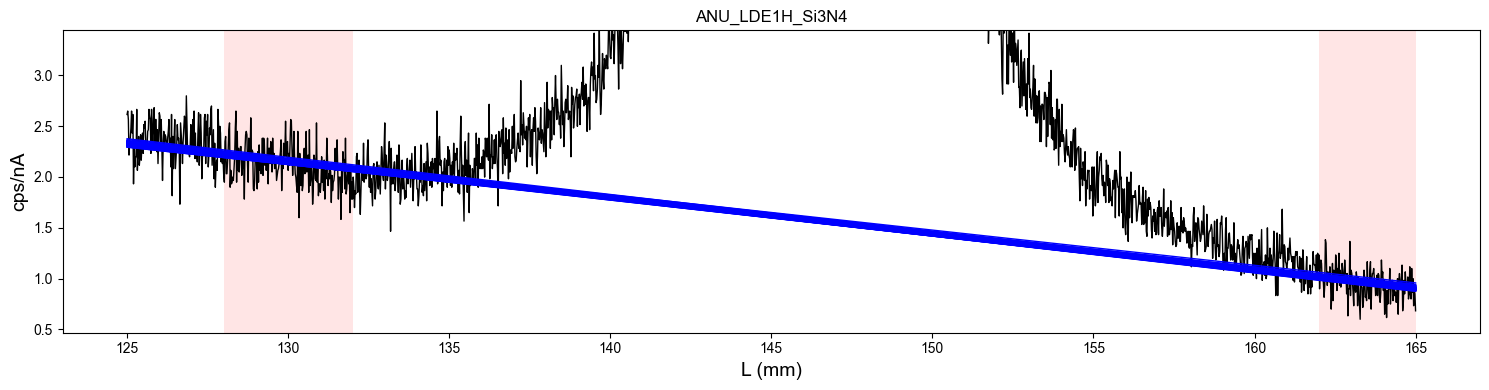

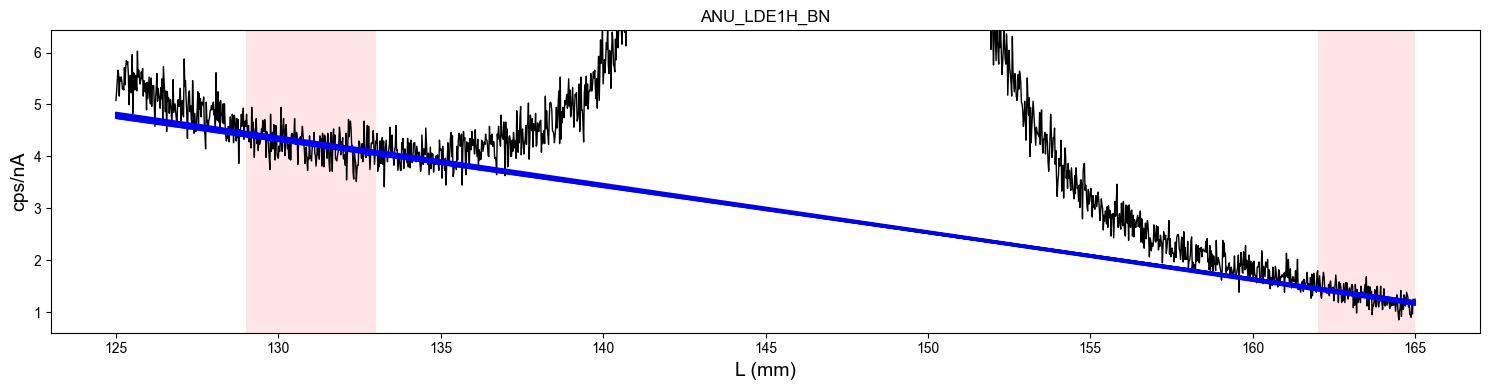

In [10]:
labs = ['StA', 'ANU']
nitrides = ['GaN', 'AlN', 'Si3N4', 'BN']

baselines = {'StA': {'LDE1': {}, 'LDE1L': {}}
            ,'ANU': {'LDE1': {}, 'LDE1H': {}}}

corrected_data = {'StA': {'LDE1': {}, 'LDE1L': {}}
                 ,'ANU': {'LDE1': {}, 'LDE1H': {}}}

for lab in labs:
    
    for xtl in data[lab].keys():
    
        for s in nitrides:
            
            roi = rois[lab][xtl][s]
            print(f'\n--- {lab} {xtl} {s} ---')

            baselines[lab][xtl][s], corrected_data[lab][xtl][s] = fit_mc_bg(
                            synthetic_data[lab][xtl][s], roi,
                            bg_type='linear', randomise_roi=True)
            
            plot_mc_bg_fits(data[lab][xtl][s], synthetic_data[lab][xtl][s],
                                        baselines[lab][xtl][s], roi,
                                        sample='_'.join([lab, xtl, s]))



--- StA LDE1 GlassA870 ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- StA LDE1L GlassA870 ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- ANU LDE1 GlassA870 ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- ANU LDE1H GlassA870 ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50


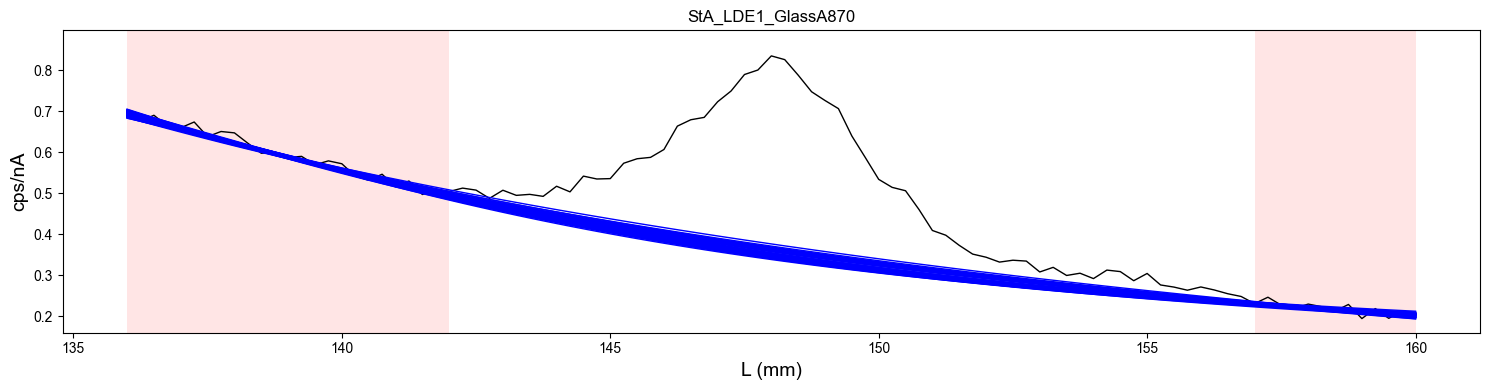

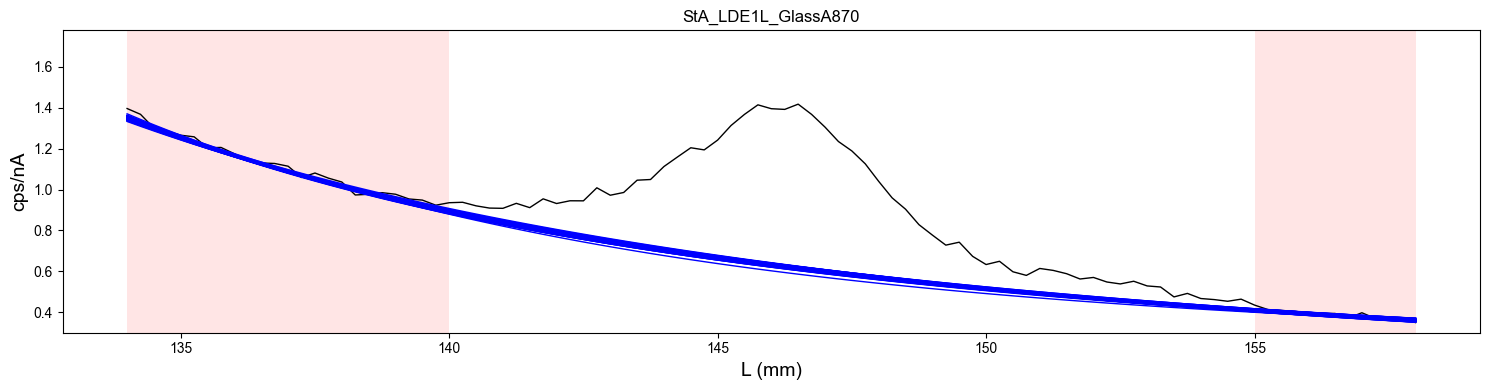

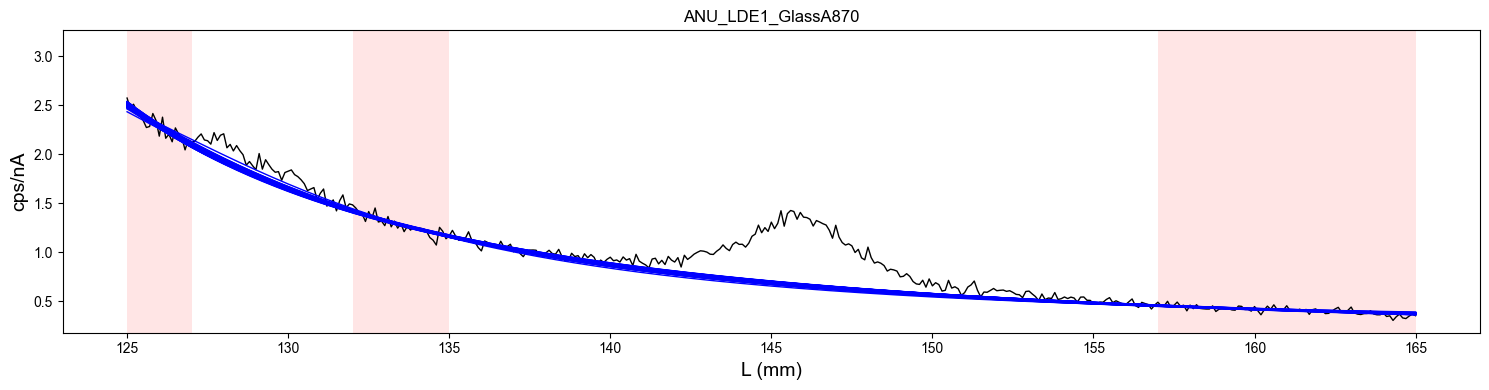

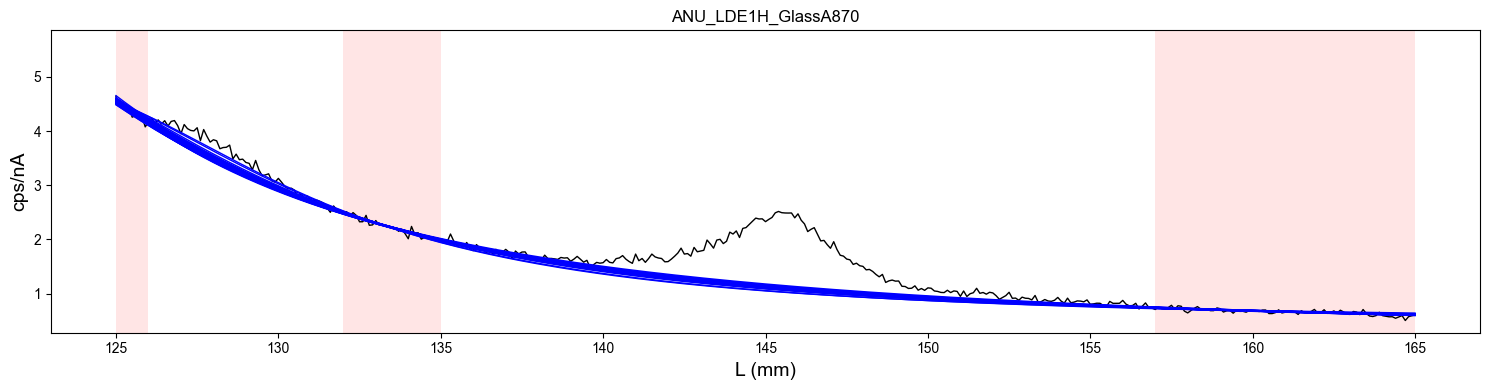

In [11]:
labs = ['StA', 'ANU']
samples = ['GlassA870']

for lab in labs:
    
    for xtl in data[lab].keys():
    
        for s in samples:
            
            roi = rois[lab][xtl][s]
            print(f'\n--- {lab} {xtl} {s} ---')

            baselines[lab][xtl][s], corrected_data[lab][xtl][s] = fit_mc_bg(
                            synthetic_data[lab][xtl][s], roi,
                            bg_type='lorentzian_plus_c', randomise_roi=True)
            
            plot_mc_bg_fits(data[lab][xtl][s], synthetic_data[lab][xtl][s],
                                        baselines[lab][xtl][s], roi,
                                        sample='_'.join([lab, xtl, s]))



--- ANU LDE1 Buddingtonite ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50

--- ANU LDE1H Buddingtonite ---
Fitting montecarlo simulation 1 of 50
Fitting montecarlo simulation 11 of 50
Fitting montecarlo simulation 21 of 50
Fitting montecarlo simulation 31 of 50
Fitting montecarlo simulation 41 of 50


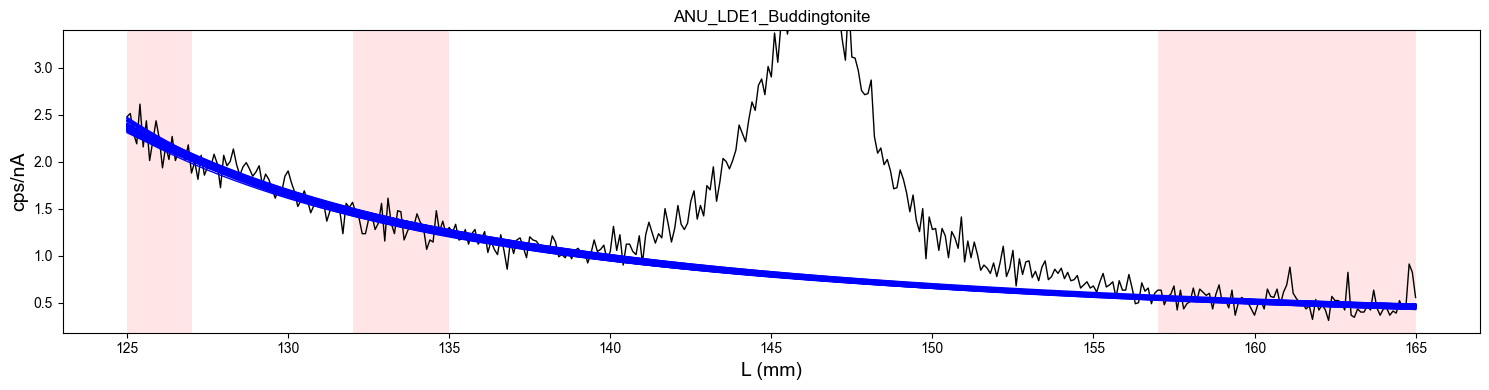

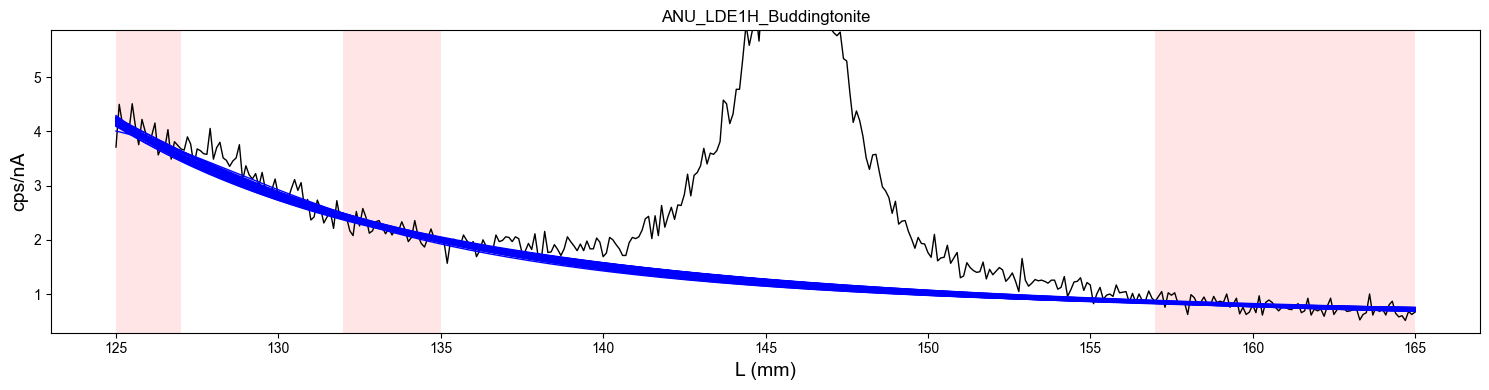

In [12]:
labs = ['ANU']
samples = ['Buddingtonite']

for lab in labs:
    
    for xtl in data[lab].keys():
    
        for s in samples:
            
            roi = rois[lab][xtl][s]
            
            print(f'\n--- {lab} {xtl} {s} ---')
            baselines[lab][xtl][s], corrected_data[lab][xtl][s] = fit_mc_bg(
                            synthetic_data[lab][xtl][s], roi,
                            bg_type='lorentzian_plus_c', randomise_roi=True)
            
            plot_mc_bg_fits(data[lab][xtl][s], synthetic_data[lab][xtl][s],
                                        baselines[lab][xtl][s], roi,
                                        sample='_'.join([lab, xtl, s]))



# Fit peaks to the background-corrected data

In [13]:
# with open('data_w_baselines.pickle', 'rb') as pickle_file:
#     data = pickle.load(pickle_file)

# with open('synthetic_data.pickle', 'rb') as pickle_file:
#     synthetic_data = pickle.load(pickle_file)
    
# with open('baseline_data.pickle', 'rb') as pickle_file:
#     baseline_data = pickle.load(pickle_file)
    
# with open('corrected_data.pickle', 'rb') as pickle_file:
#     corrected_data = pickle.load(pickle_file)

# Fitting the background-subtracted data

In [14]:
fit_dict = {'StA': {'LDE1': {}, 'LDE1L': {}}
             ,'ANU': {'LDE1': {}, 'LDE1H': {}}}

mc_fit_dict = {'StA': {'LDE1': {}, 'LDE1L': {}}
             ,'ANU': {'LDE1': {}, 'LDE1H': {}}}

## BN

### Fit to actual data:

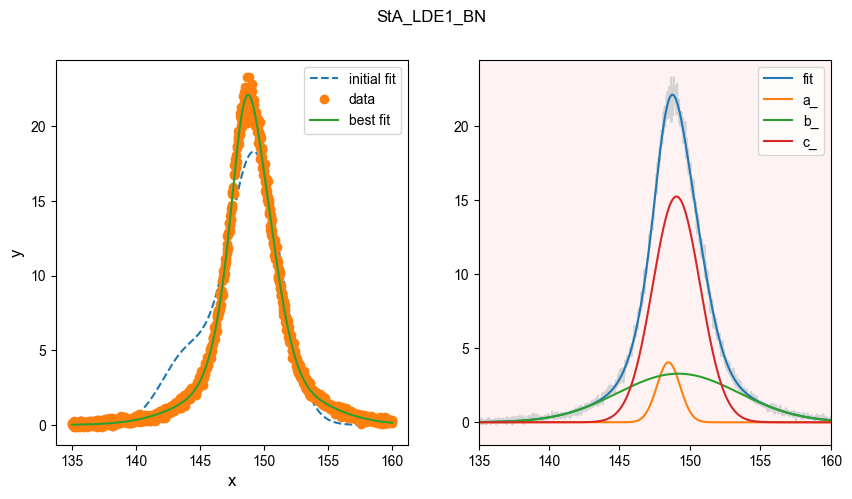

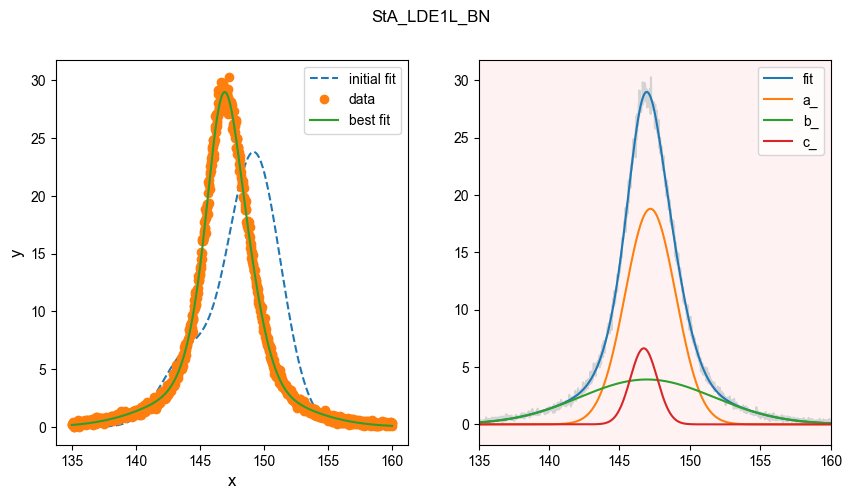

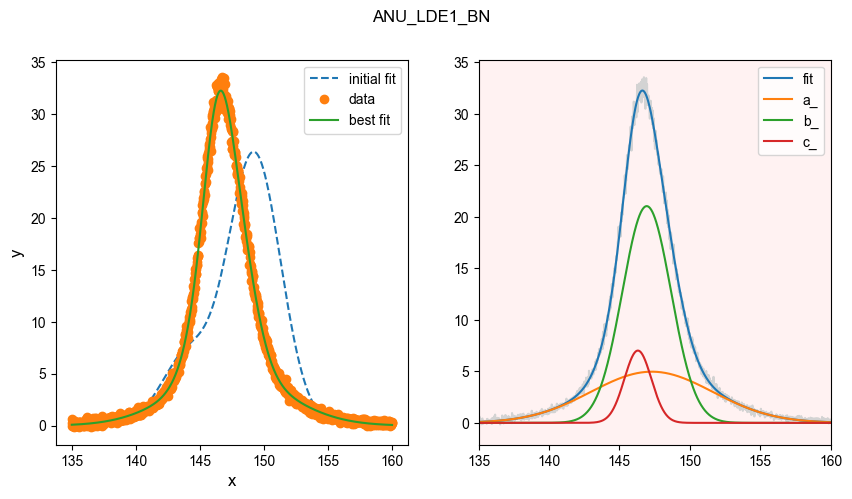

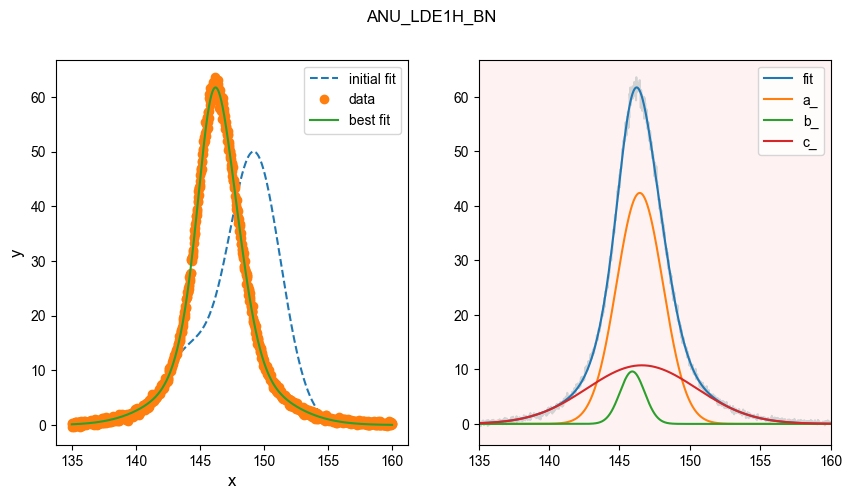

In [15]:
lab = 'StA'
s = 'BN'

for xtl in ['LDE1', 'LDE1L']:
    
    roi = [[135, 160]]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
            {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                        y_column='cps_per_nA_corrected',
                                                        roi=roi,
                                                        samplename='_'.join([lab, xtl, s]))
    
lab = 'ANU'
for xtl in ['LDE1', 'LDE1H']:
    
    roi = [[135, 160]]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
            {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                        y_column='cps_per_nA_corrected',
                                                        roi=roi,
                                                        samplename='_'.join([lab, xtl, s]))


### Montecarlo fit:

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


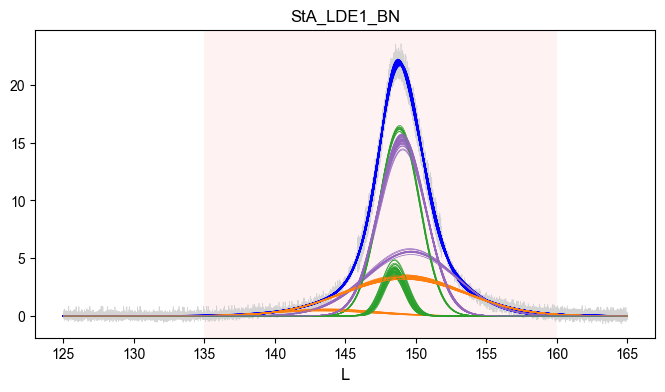

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


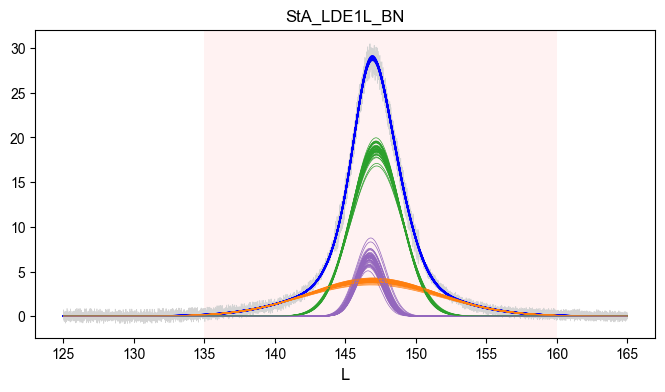

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


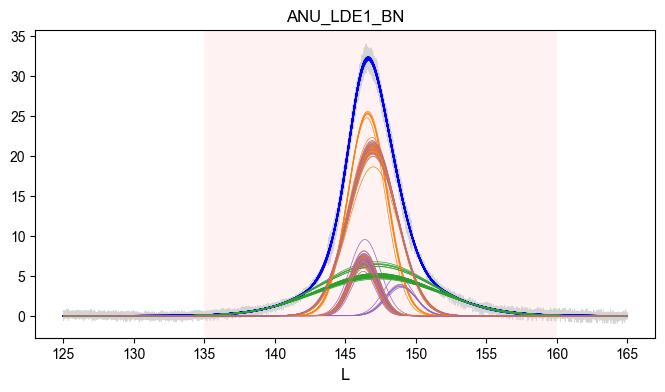

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


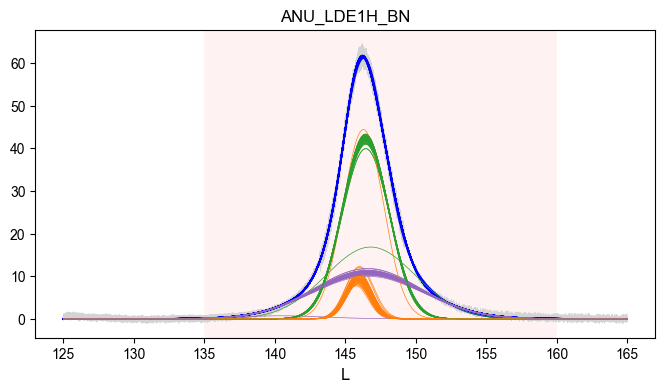

In [16]:
lab = 'StA'

for xtl in ['LDE1', 'LDE1L']:
    
    roi = [[135, 160]]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
            {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]
    
    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))
    
lab = 'ANU'

for xtl in ['LDE1', 'LDE1H']:
    
    roi = [[135, 160]]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
            {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]
    
    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))
    
 # Play a sound when the cell finishes running
# Audio(filename=sound_file, autoplay=True)

## GaN

### Fit to acutal data

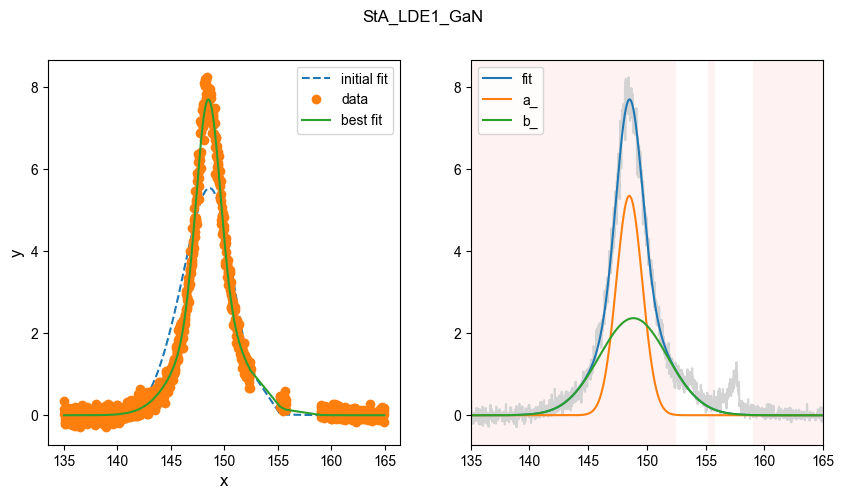

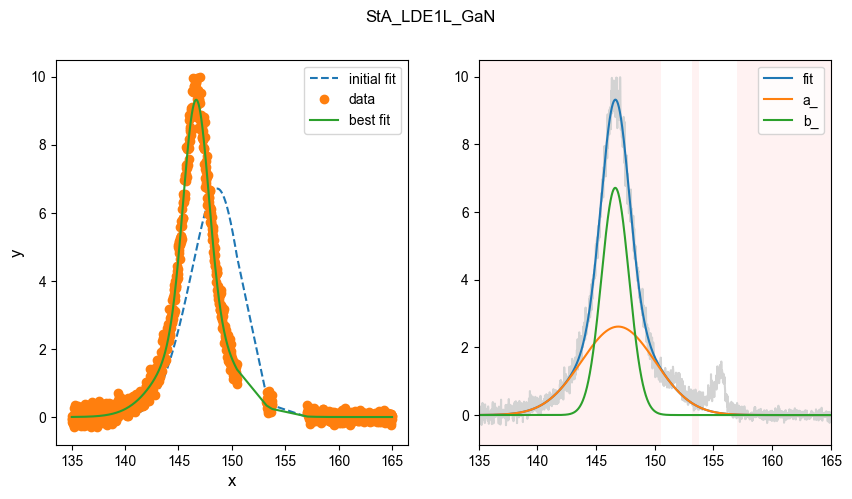

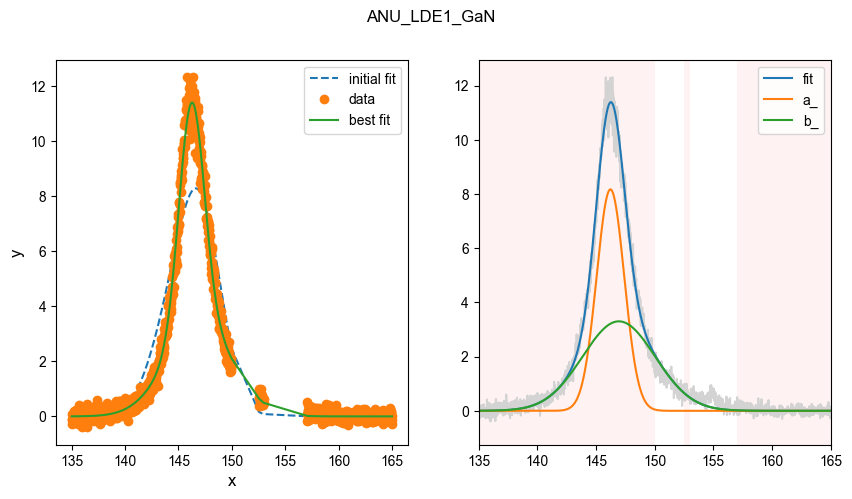

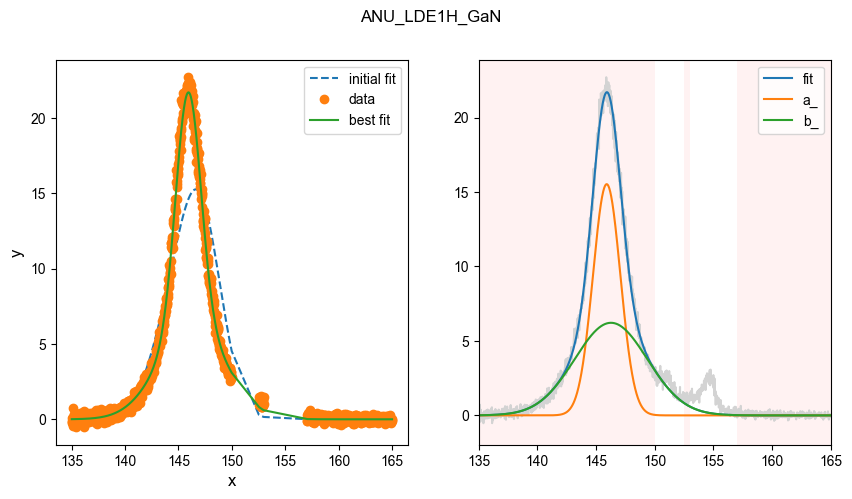

In [17]:
lab = 'StA'
s = 'GaN'

rois = {'LDE1': [[135,152.5], [155.2,155.8], [159,165]],
         'LDE1L': [[135,150.5], [153.2,153.8], [157,165]]}


for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 146, 'sigma': 2},
        ]
    
    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                        y_column='cps_per_nA_corrected',
                                                        roi=roi,
                                                        samplename='_'.join([lab, xtl, s]))
    
lab = 'ANU'
rois = {'LDE1': [[135,150],[152.5,153],[157,165]]
        ,'LDE1H': [[135,150],[152.5,153],[157,165]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                        y_column='cps_per_nA_corrected',
                                                        roi=roi,
                                                        samplename='_'.join([lab, xtl, s]))


Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


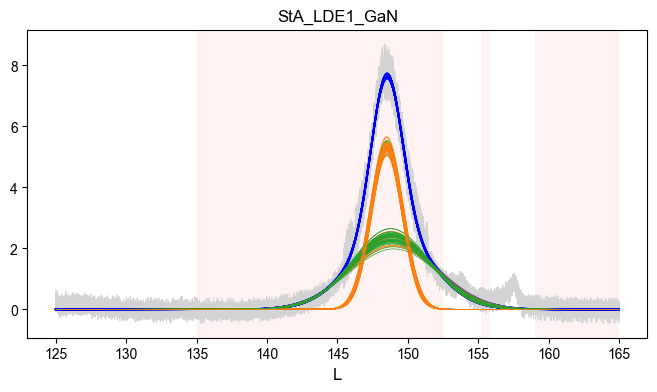

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


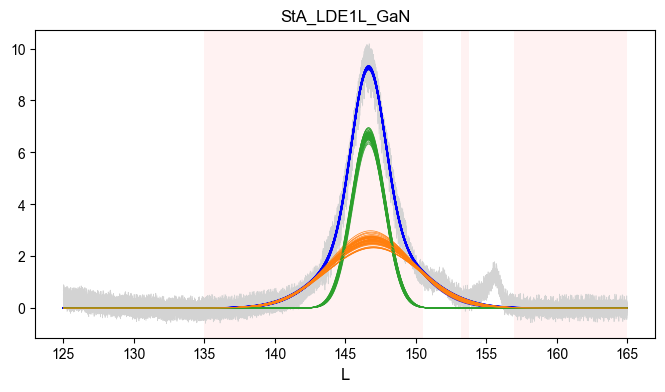

In [18]:
lab = 'StA'
s = 'GaN'

rois = {'LDE1': [[135,152.5], [155.2,155.8], [159,165]],
         'LDE1L': [[135,150.5], [153.2,153.8], [157,165]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


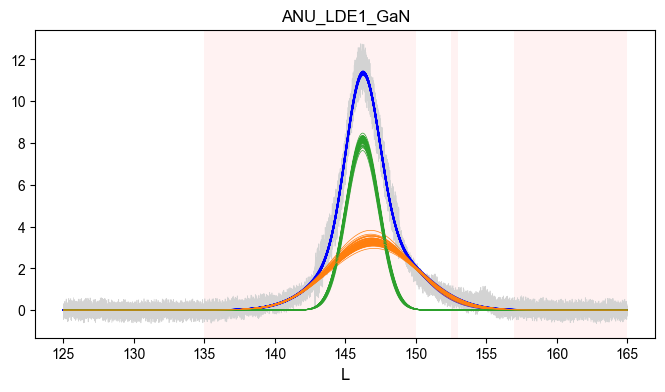

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


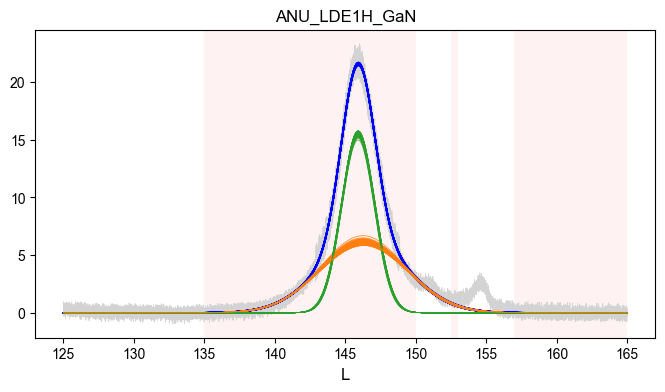

In [19]:
s= 'GaN'
lab = 'ANU'
rois = {'LDE1': [[135,150],[152.5,153],[157,165]]
        ,'LDE1H': [[135,150],[152.5,153],[157,165]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))
# Play a sound when the cell finishes running
# Audio(filename=sound_file, autoplay=True)

# AlN

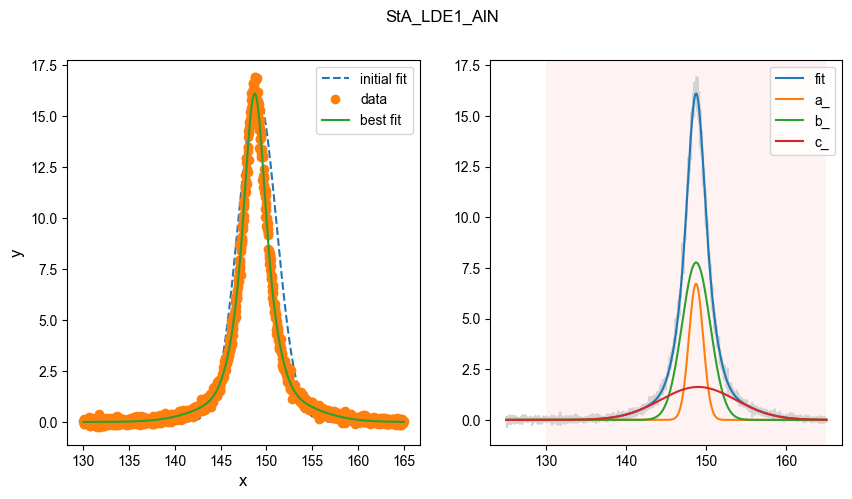

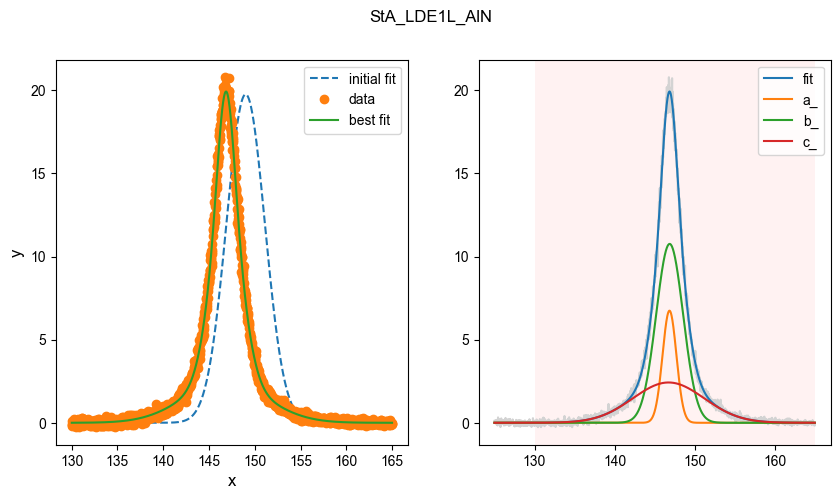

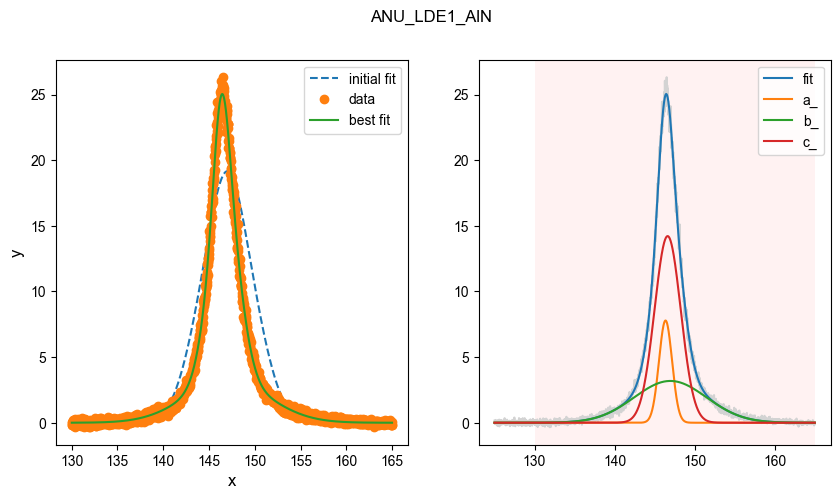

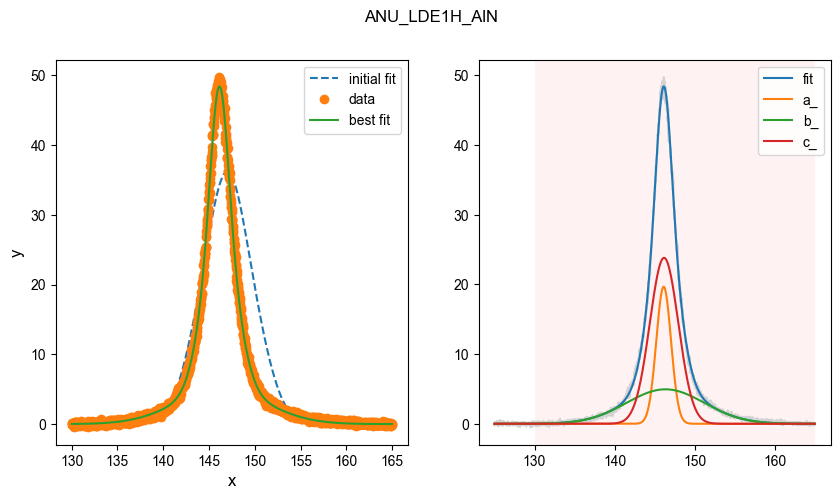

In [20]:
lab = 'StA'
s = 'AlN'

rois = {'LDE1': [[130, 165]],
         'LDE1L': [[130, 165]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 148, 'sigma': 2},
                 {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},

        ]
    
    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)
    
lab = 'ANU'
rois = {'LDE1': [[130, 165]],
         'LDE1H': [[130, 165]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
                 {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},

            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)


Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


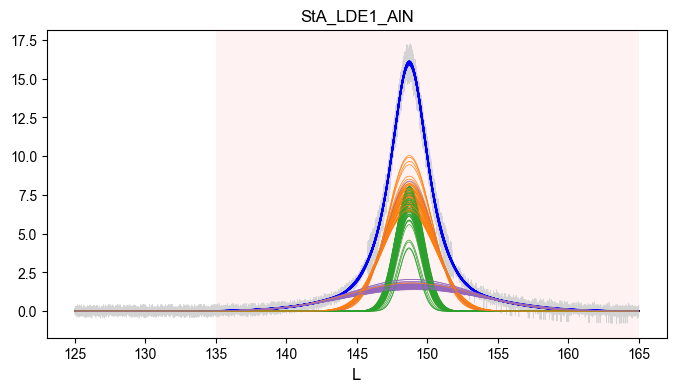

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


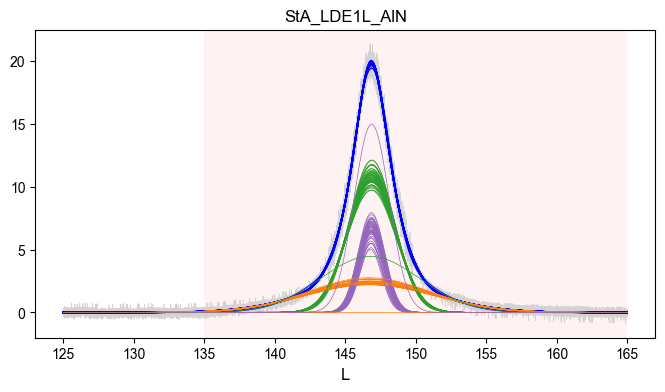

In [21]:
lab = 'StA'
s = 'AlN'

rois = {'LDE1': [[135, 165]],
         'LDE1L': [[135, 165]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
                 {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


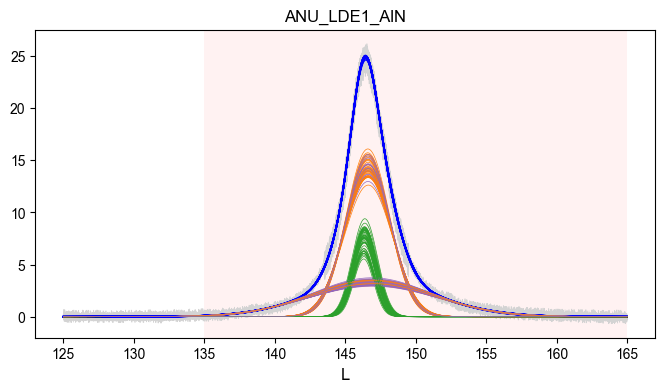

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


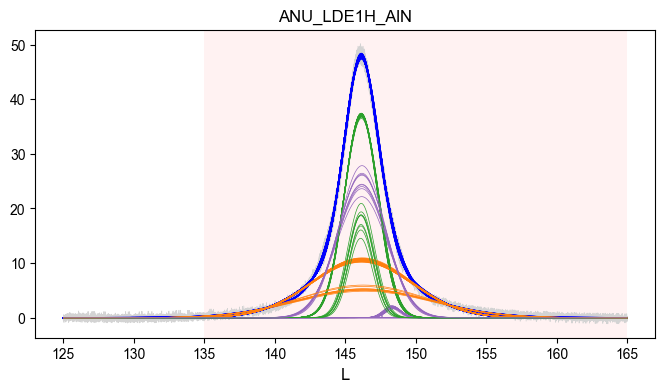

In [22]:
lab = 'ANU'
s = 'AlN'

rois = {'LDE1': [[135, 165]],
         'LDE1H': [[135, 165]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 148, 'sigma': 2},
                 {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

# Si3N4

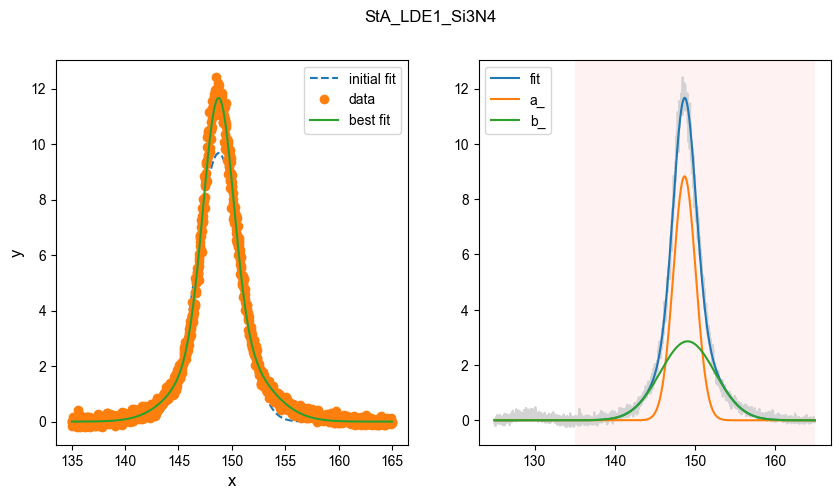

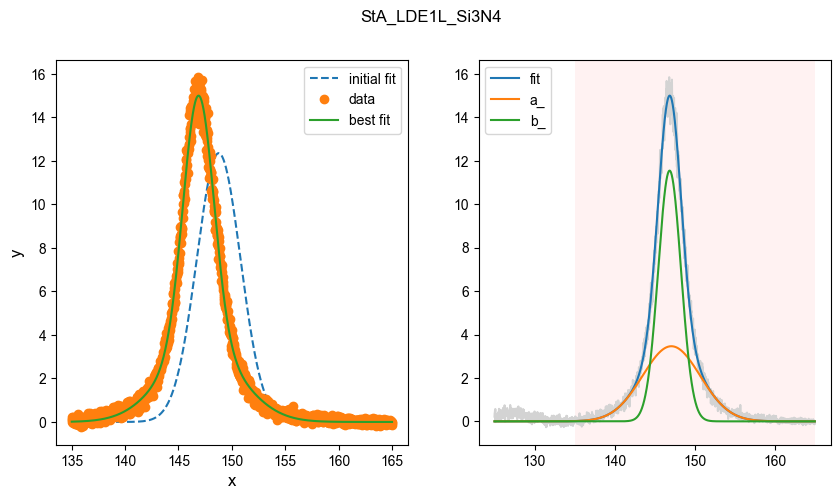

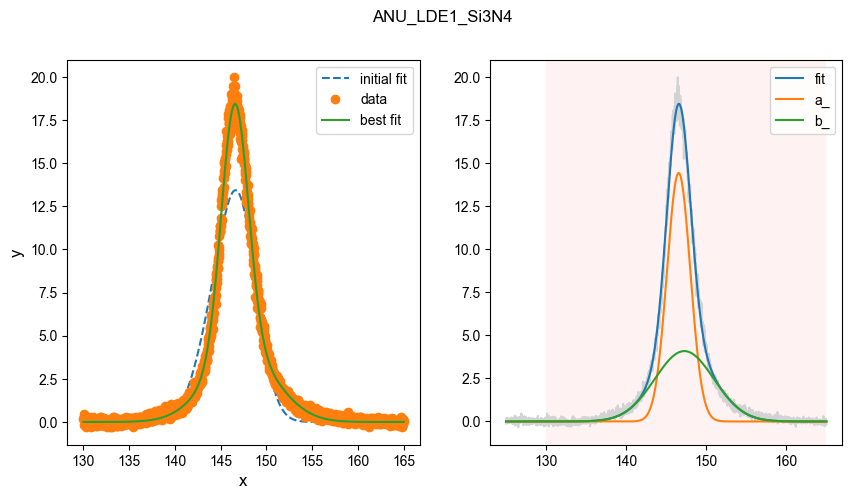

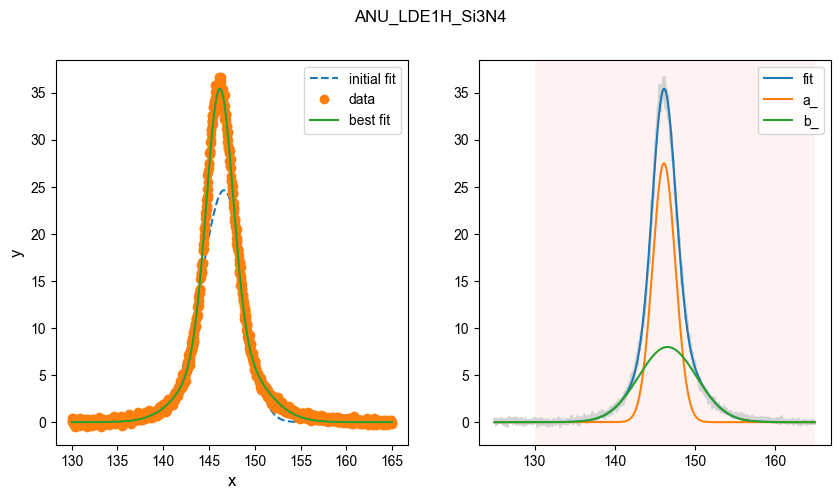

In [23]:
lab = 'StA'
s = 'Si3N4'

rois = {'LDE1': [[135, 165]],
         'LDE1L': [[135, 165]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 148, 'sigma': 2},

        ]
    
    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)
    
lab = 'ANU'
rois = {'LDE1': [[130, 165]],
         'LDE1H': [[130, 165]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)


Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


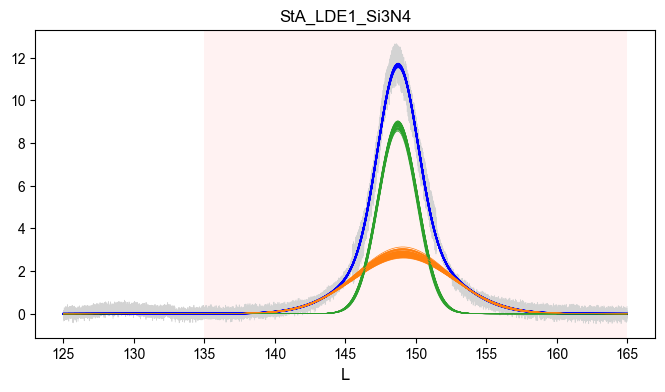

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


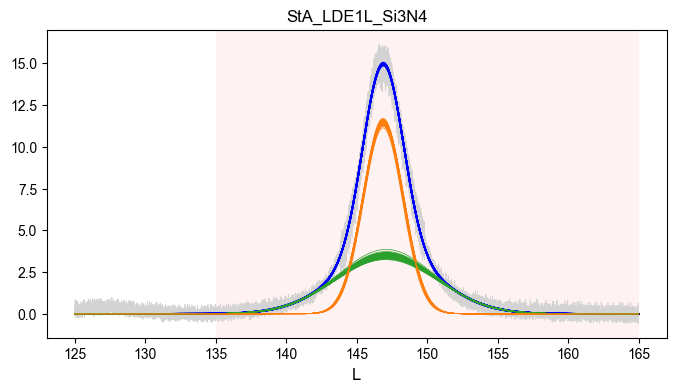

In [24]:
lab = 'StA'
s = 'Si3N4'

rois = {'LDE1': [[135, 165]],
         'LDE1L': [[135, 165]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 149, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 148, 'sigma': 2},
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


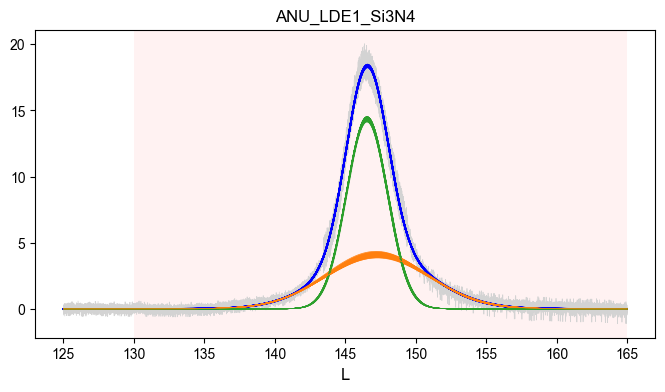

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


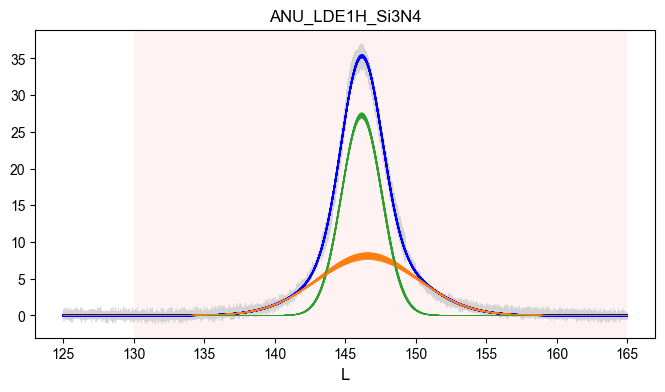

In [25]:
lab = 'ANU'
s = 'Si3N4'

rois = {'LDE1': [[130, 165]],
         'LDE1H': [[130, 165]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 148, 'sigma': 2},
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

# GlassA870

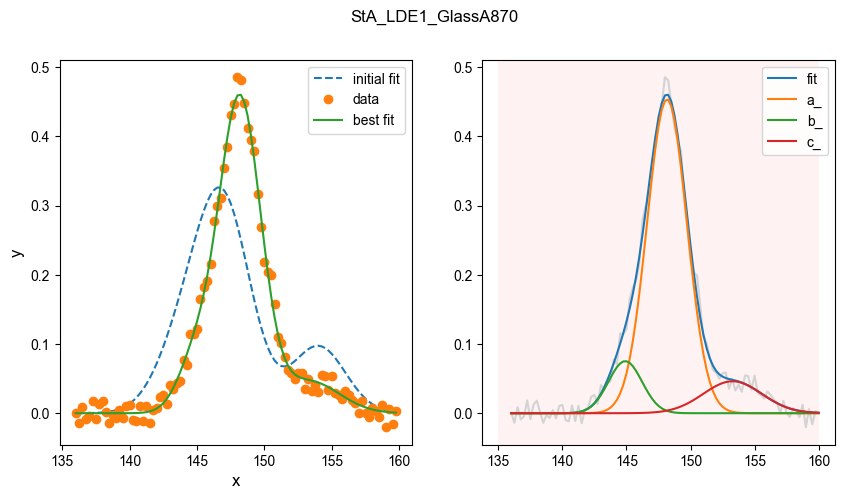

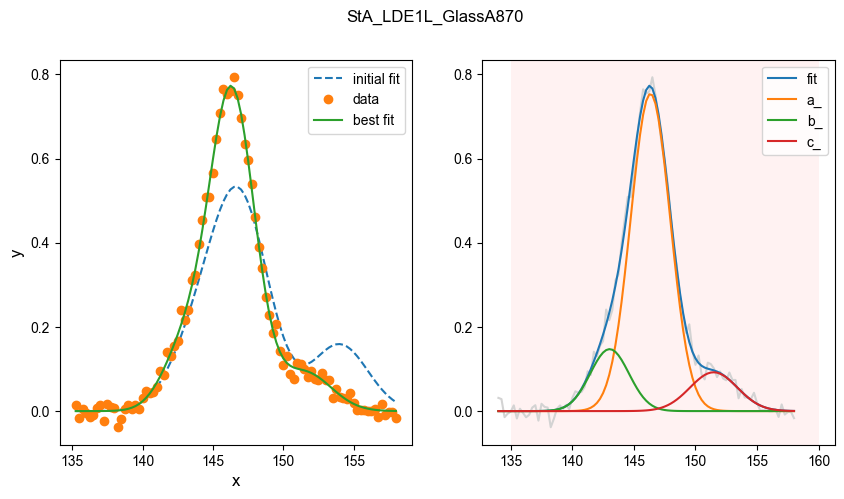

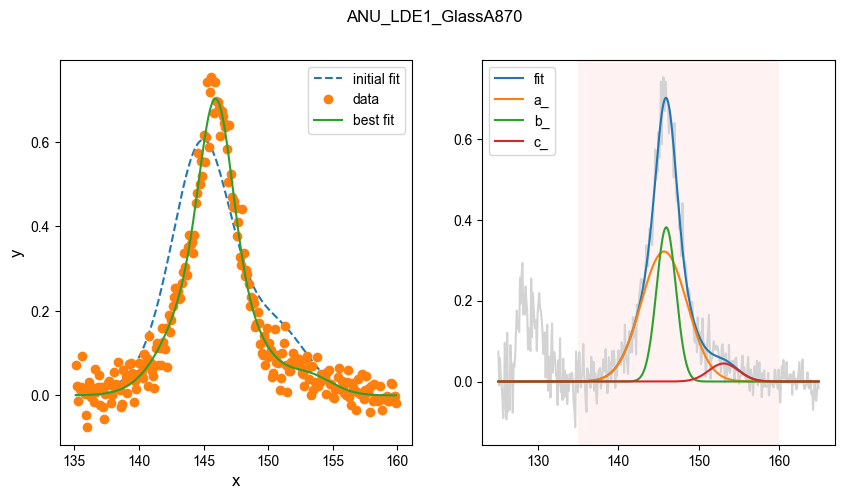

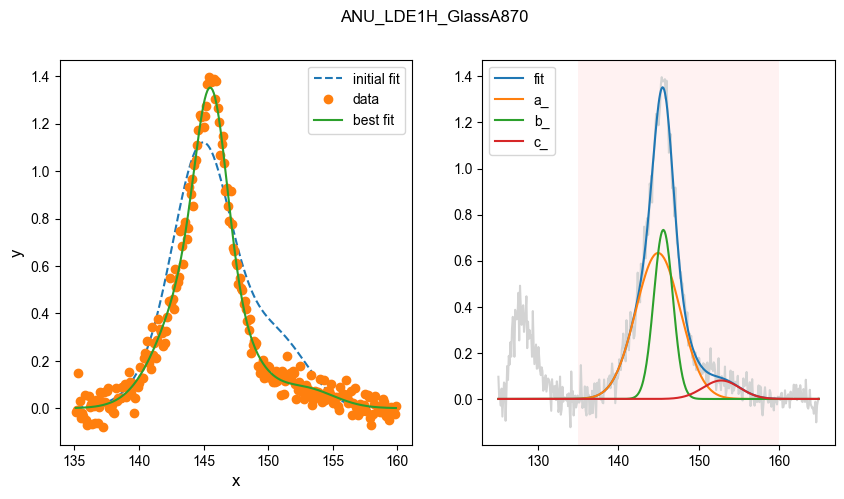

In [26]:
lab = 'StA'
s = 'GlassA870'

rois = {'LDE1': [[135, 160]],
         'LDE1L': [[135, 160]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
                {'prefix': 'c_', 'amplitude': ymax, 'center': 154, 'sigma': 2,
                                                'sigma_min': 0, 'sigma_max': 2.4,
                                                'center_min': 151, 'center_max':156},
        ]
    
    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)
    
lab = 'ANU'
rois = {'LDE1': [[135, 160]],
         'LDE1H': [[135, 160]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 145, 'sigma': 3,
                                                    'sigma_min':0, 'sigma_max':3},
            {'prefix': 'b_', 'amplitude': ymax*2, 'center': 144.9, 'sigma': 2},
            {'prefix': 'c_', 'amplitude': ymax, 'center': 151, 'sigma': 2.3,
                                                'sigma_min': 1, 'sigma_max': 2.4,
                                                'center_min': 150, 'center_max':160},
            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)


Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


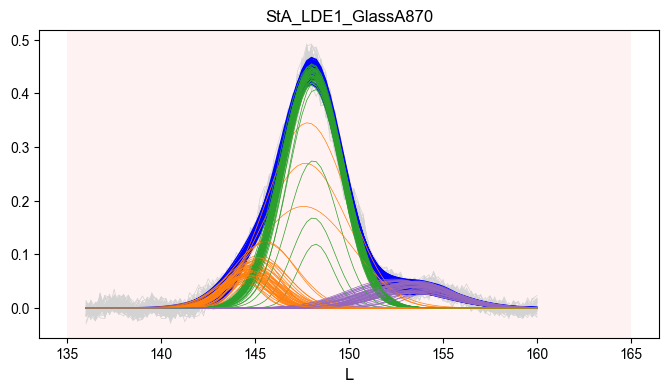

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


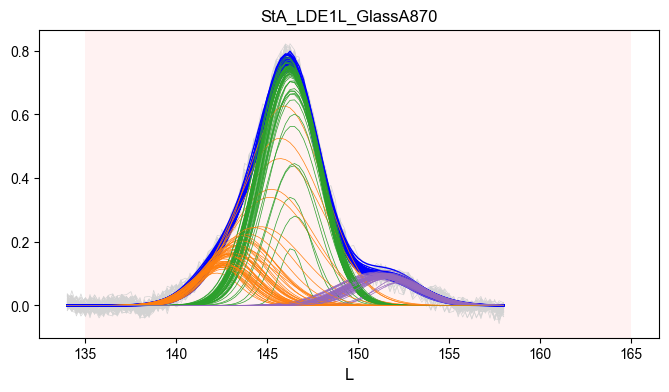

In [27]:
lab = 'StA'
s = 'GlassA870'

rois = {'LDE1': [[135, 165]],
         'LDE1L': [[135, 165]]}

for xtl in ['LDE1', 'LDE1L']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
                {'prefix': 'c_', 'amplitude': ymax, 'center': 154, 'sigma': 2,
                                                'sigma_min': 0.5, 'sigma_max': 2.4,
                                                'center_min': 151, 'center_max':156},
                ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


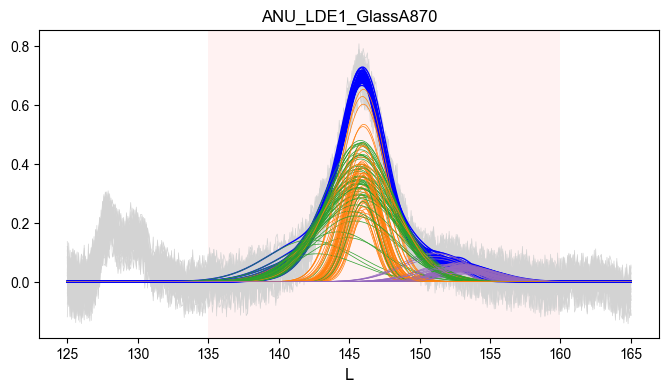

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


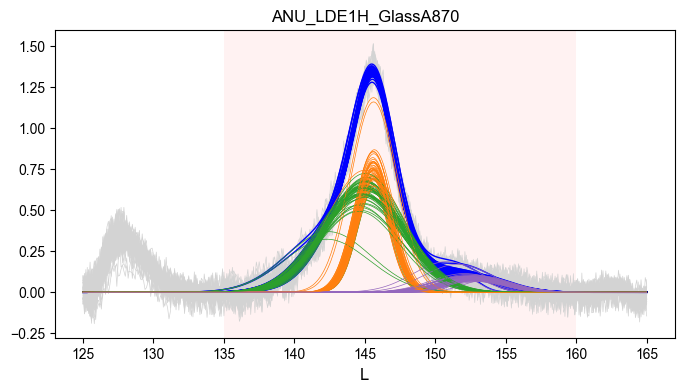

In [28]:
lab = 'ANU'
s = 'GlassA870'

rois = {'LDE1': [[135, 160]],
         'LDE1H': [[135, 160]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
            {'prefix': 'a_',  'amplitude': ymax*3, 'center': 145, 'sigma': 3,
                                                    'sigma_min':0, 'sigma_max':3},
            {'prefix': 'b_', 'amplitude': ymax*2, 'center': 144.9, 'sigma': 2},
            {'prefix': 'c_', 'amplitude': ymax, 'center': 151, 'sigma': 2.3,
                                                'sigma_min': 1, 'sigma_max': 2.4,
                                                'center_min': 150, 'center_max':160},
    ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

## Buddingtonite

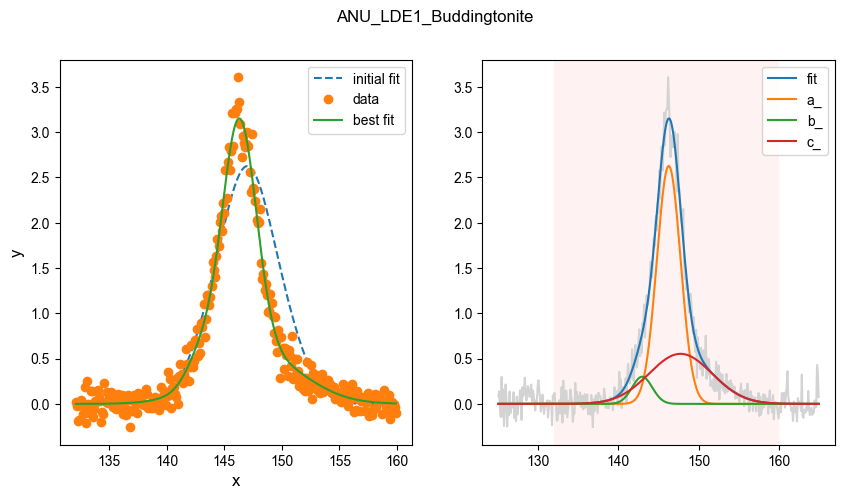

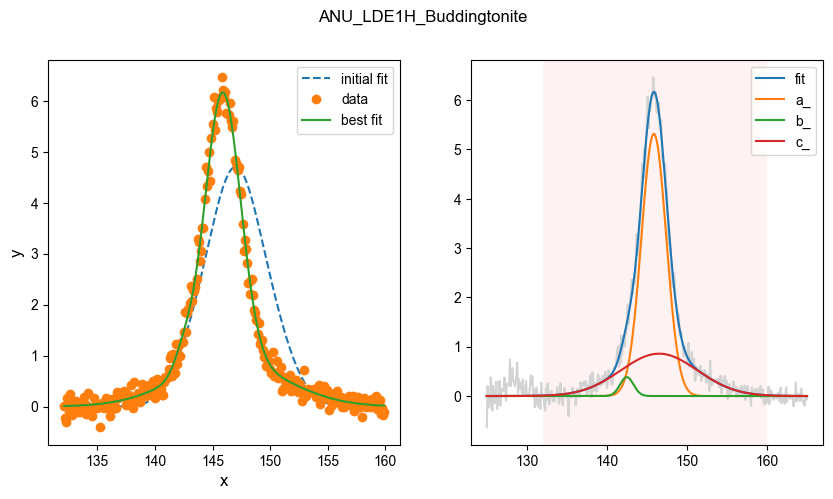

In [29]:
s = 'Buddingtonite'

lab = 'ANU'
rois = {'LDE1': [[132, 160]],
         'LDE1H': [[132, 160]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
                 {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2},
            ]

    fit_dict[lab][xtl][s] = fit_multiple_gaussians(data[lab][xtl][s], pk_params,
                                                    y_column='cps_per_nA_corrected',
                                                    roi=roi,
                                                    samplename='_'.join([lab, xtl, s]),
                                                    plot=True, plot_only_roi=False)


Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


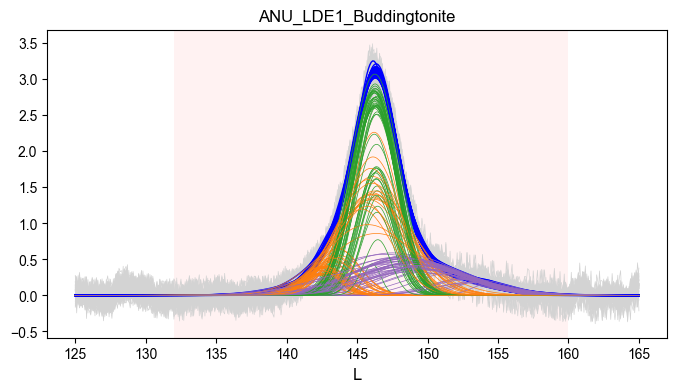

Fitting montecarlo simulation 1 of 51
Fitting montecarlo simulation 11 of 51
Fitting montecarlo simulation 21 of 51
Fitting montecarlo simulation 31 of 51
Fitting montecarlo simulation 41 of 51


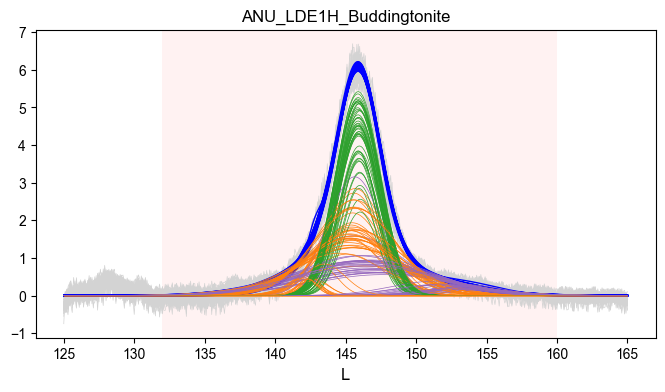

In [30]:
lab = 'ANU'
s = 'Buddingtonite'

rois = {'LDE1': [[132, 160]],
         'LDE1H': [[132, 160]]}

for xtl in ['LDE1', 'LDE1H']:
    
    roi = rois[xtl]
    df = select_roi(data[lab][xtl][s], roi)
    ymax = df.cps_per_nA_corrected.max()
    
    pk_params = [
               {'prefix': 'a_',  'amplitude': ymax*3, 'center': 147, 'sigma': 2},
               {'prefix': 'b_', 'amplitude': ymax, 'center': 144, 'sigma': 2},
                 {'prefix': 'c_', 'amplitude': ymax, 'center': 150, 'sigma': 2}
            ]

    mc_fit_dict[lab][xtl][s] = fit_multiple_gaussians_mc(corrected_data[lab][xtl][s], pk_params,
                                                              roi=roi, samplename='_'.join([lab, xtl, s]))

# Calculate height/area ratios

For the fits to the actual data:

In [31]:
lab = 'StA'
xtl = 'LDE1L'
s = 'GaN'

amp_keys = [k for k in fit_dict[lab][xtl][s].params.keys() if 'amplitude' in k]
amp_vals = [fit_dict[lab][xtl][s].params[amp_key].value for amp_key in amp_keys]
sum_amplitude = sum(amp_vals)

print(sum_amplitude)

40.3369267307634


In [32]:
fitted_curve = fit_dict[lab][xtl][s].eval(x=data[lab][xtl][s].L)
trapz_area = np.trapz(fitted_curve, x=data[lab][xtl][s].L)
print(trapz_area)

40.3369266489103


Yes! The area under the fit is the same based on the sum of amplitudes or a trapezoidal integration method. So I will use the sum of amplitudes!

In [33]:
def get_height_area_ratio(fit_result_object, xvals, prefix_component_to_exclude=None):
    
    """
    fit_result_object = an lmfit.fit_result object
    xvals = an array over which to evaluate the fit result, in order to find peak height
    prefix_component_to_exclude = string giving prefix of the component to exclude from the
                                area calculation (e.g. to exclude a shoulder). Should be
                                something like 'c_'.
    """

    amp_keys = [k for k in fit_result_object.params.keys() if 'amplitude' in k]
    
    amp_vals = []
    
    for amp_key in amp_keys:
        if amp_key[0:2] != prefix_component_to_exclude:
            amp_vals.append(fit_result_object.params[amp_key].value)
            
    area_fit = sum(amp_vals)

    fitted_curve = fit_result_object.eval(x=xvals)
    height_fit = fitted_curve.max()

    ht_area_ratio = height_fit / area_fit
    
    return ht_area_ratio

In [34]:
def get_height_area_ratio_mc_avg(fit_result_object_list, xvals, prefix_component_to_exclude=None):
    
    """
    fit_result_object_list = a list of lmfit.fit_result objects over which to find mean and stdev
    xvals = an array over which to evaluate the fit result, in order to find peak height
    prefix_component_to_exclude = string giving prefix of the component to exclude from the
                                area calculation (e.g. to exclude a shoulder). Should be
                                something like 'c_'.
    """
    
    ht_area_ratio_list = []
    
    for i, fit_result_object in enumerate(fit_result_object_list):
        print('        Getting height/area for mc model #{}'.format(i))
        ht_area_of_this_model = get_height_area_ratio(fit_result_object, xvals, prefix_component_to_exclude)
        ht_area_ratio_list.append(ht_area_of_this_model)
        
    ht_area_mean = np.array(ht_area_ratio_list).mean()
    ht_area_stdev = np.array(ht_area_ratio_list).std()

    return ht_area_mean, ht_area_stdev

In [35]:
def get_peak_pos(fit_result_object, xvals, prefix_component_to_exclude=None):
    
    """
    fit_result_object = an lmfit.fit_result object
    xvals = an array over which to evaluate the fit result, in order to find peak height
    prefix_component_to_exclude = string giving prefix of the component to exclude from the
                                area calculation (e.g. to exclude a shoulder). Should be
                                something like 'c_'.
                                **** NOT IMPLEMENTED **** 
    """

    fitted_curve = fit_result_object.eval(x=xvals)
    peak_pos_idx = fitted_curve.argmax()
    peak_pos = xvals[peak_pos_idx]
    
    return peak_pos

In [36]:
def get_peak_pos_mc_avg(fit_result_object_list, xvals, prefix_component_to_exclude=None):
    
    """
    fit_result_object_list = a list of lmfit.fit_result objects over which to find mean and stdev
    xvals = an array over which to evaluate the fit result, in order to find peak height
    prefix_component_to_exclude = string giving prefix of the component to exclude from the
                                area calculation (e.g. to exclude a shoulder). Should be
                                something like 'c_'.
                                *** NOT IMPLEMENTED ***
    """
    
    peak_pos_list = []
    
    for i, fit_result_object in enumerate(fit_result_object_list):
        print('        Getting peak pos for mc model #{}'.format(i))
        peak_pos_of_this_model = get_peak_pos(fit_result_object, xvals, prefix_component_to_exclude)
        peak_pos_list.append(peak_pos_of_this_model)
        
    peak_pos_mean = np.array(peak_pos_list).mean()
    peak_pos_stdev = np.array(peak_pos_list).std()

    return peak_pos_mean, peak_pos_stdev

In [37]:
ht_area_dict = {'StA': {'LDE1': None, 'LDE1L': None}
                ,'ANU': {'LDE1': None, 'LDE1H': None}}

In [38]:
xvals = np.arange(120, 180, 0.01)
len(xvals)

6000

In [39]:
for lab in ['StA', 'ANU']:
    
    for xtl in ht_area_dict[lab].keys():
        
        samples = []
        ht_area_ratios = []
        ht_area_ratios_mc_mean = []
        ht_area_ratios_mc_stdev = []
        
        for s in fit_dict[lab][xtl].keys():
            
            print(s)
            samples.append(s)
            
            print('    Getting height/area ratios from data')
            ht_area = get_height_area_ratio(fit_dict[lab][xtl][s],
                                xvals,
                                prefix_component_to_exclude=None)
            
            print('    Getting height/area ratios from mc simulations')
            ht_area_mean, ht_area_stdev = get_height_area_ratio_mc_avg(mc_fit_dict[lab][xtl][s],
                                xvals,
                                prefix_component_to_exclude=None)
            
            ht_area_ratios.append(ht_area)
            ht_area_ratios_mc_mean.append(ht_area_mean)
            ht_area_ratios_mc_stdev.append(ht_area_stdev)
            
        print('Creating final tables')
        ht_area_dict[lab][xtl] = pd.DataFrame({'Sample': samples
                                               ,'ht_area_ratio': ht_area_ratios
                                               ,'ht_area_ratio_mc_mean': ht_area_ratios_mc_mean
                                               ,'ht_area_ratio_mc_stdev': ht_area_ratios_mc_stdev})


BN
    Getting height/area ratios from data
    Getting height/area ratios from mc simulations
        Getting height/area for mc model #0
        Getting height/area for mc model #1
        Getting height/area for mc model #2
        Getting height/area for mc model #3
        Getting height/area for mc model #4
        Getting height/area for mc model #5
        Getting height/area for mc model #6
        Getting height/area for mc model #7
        Getting height/area for mc model #8
        Getting height/area for mc model #9
        Getting height/area for mc model #10
        Getting height/area for mc model #11
        Getting height/area for mc model #12
        Getting height/area for mc model #13
        Getting height/area for mc model #14
        Getting height/area for mc model #15
        Getting height/area for mc model #16
        Getting height/area for mc model #17
        Getting height/area for mc model #18
        Getting height/area for mc model #19
        Getting

In [40]:
peak_pos_dict = {'StA': {'LDE1': None, 'LDE1L': None}
                ,'ANU': {'LDE1': None, 'LDE1H': None}
              }

for lab in ['StA', 'ANU']:
    
    for xtl in peak_pos_dict[lab].keys():
        
        samples = []

        peak_pos = []
        peak_pos_mc_mean = []
        peak_pos_mc_stdev = []
        
        for s in fit_dict[lab][xtl].keys():
            
            print(s)
            
            samples.append(s)
           
            print('    Getting peak pos')
           
            pos = get_peak_pos(fit_dict[lab][xtl][s],
                                   xvals)

            print('    Getting peak pos from mc simulations')
            pos_mean, pos_stdev = get_peak_pos_mc_avg(mc_fit_dict[lab][xtl][s],
                                   xvals,
                                   prefix_component_to_exclude=None)
            
            peak_pos.append(pos)
            peak_pos_mc_mean.append(pos_mean)
            peak_pos_mc_stdev.append(pos_stdev)
        
        print('Creating final tables')
        peak_pos_dict[lab][xtl] = pd.DataFrame({'Sample': samples
                                                ,'peak_pos': peak_pos
                                                ,'peak_pos_mc_mean': peak_pos_mc_mean
                                                ,'peak_pos_mc_stdev': peak_pos_mc_stdev})


BN
    Getting peak pos
    Getting peak pos from mc simulations
        Getting peak pos for mc model #0
        Getting peak pos for mc model #1
        Getting peak pos for mc model #2
        Getting peak pos for mc model #3
        Getting peak pos for mc model #4
        Getting peak pos for mc model #5
        Getting peak pos for mc model #6
        Getting peak pos for mc model #7
        Getting peak pos for mc model #8
        Getting peak pos for mc model #9
        Getting peak pos for mc model #10
        Getting peak pos for mc model #11
        Getting peak pos for mc model #12
        Getting peak pos for mc model #13
        Getting peak pos for mc model #14
        Getting peak pos for mc model #15
        Getting peak pos for mc model #16
        Getting peak pos for mc model #17
        Getting peak pos for mc model #18
        Getting peak pos for mc model #19
        Getting peak pos for mc model #20
        Getting peak pos for mc model #21
        Getting peak 

## Save the height/area results

In [41]:
for lab in ['StA', 'ANU']:
    for xtl in ht_area_dict[lab].keys():
        ht_area_dict[lab][xtl].to_csv(f'../data/processed/peak_shapes/ht_area_tables/{lab}_{xtl}.csv')

## Save the peak position results

In [42]:
for lab in ['StA', 'ANU']:
    for xtl in peak_pos_dict[lab].keys():
        peak_pos_dict[lab][xtl].to_csv(f'../data/processed/peak_shapes/peak_pos_tables/{lab}_{xtl}.csv')

## Save the fitted curves

In [43]:
for lab in ['StA', 'ANU']:
    for xtl in fit_dict[lab].keys():
        for s in fit_dict[lab][xtl].keys():
            fitted_curve = fit_dict[lab][xtl][s].eval(x=data[lab][xtl][s]['L'])
            data[lab][xtl][s]['fit'] = fitted_curve
            data[lab][xtl][s].to_csv(f'../data/processed/peak_shapes/data_with_fits_{lab}/{xtl}/{s}.csv')

In [44]:
ht_area_dict["ANU"]["LDE1"]

Sample  ht_area_ratio  ht_area_ratio_mc_mean  ht_area_ratio_mc_stdev
0             BN       0.199436               0.199091                0.000570
1            GaN       0.229189               0.228584                0.001308
2            AlN       0.227174               0.226311                0.000743
3          Si3N4       0.203827               0.203417                0.000741
4      GlassA870       0.191372               0.191377                0.007849
5  Buddingtonite       0.195100               0.192313                0.003192